In [197]:
import numpy as np
import array
from scipy import linalg
from scipy.spatial.transform import Rotation as R
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.collections
import matplotlib.patches
import pg_fitter_tools as fit
import sk_geo_tools as geo
import cv2
import re
from collections import Counter

In [198]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [199]:
#%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [200]:
## input intrinsic parameters and build camera matrix and distortion parameter array

def camera_model(fx,fy,cx,cy,k1,k2,p1,p2,skew):
    focal_length = np.array([fx,fy])
    principle_point = np.array([cx,cy])
    radial_distortion = np.array([k1,k2])
    tangential_distortion = np.array([p1,p2])
    camera_matrix = fit.build_camera_matrix(focal_length, principle_point, skew)
    distortion = fit.build_distortion_array(radial_distortion, tangential_distortion)
    return focal_length, principle_point, radial_distortion, tangential_distortion, camera_matrix, distortion

## starting point for parameter values before fit
## model values obtained from MATLAB for the old drone calibration
fx, fy, cx, cy, k1, k2, k3, p1, p2, skew = 3110.7, 3112.8, 1988.2, 1510.5, -0.2497, 0.1693, 0, -9.7426e-4, -8.7611e-4, -6.8332

focal_length, principle_point, radial_distortion, tangential_distortion, camera_matrix, distortion = camera_model(fx, fy, cx, cy, k1, k2, p1, p2, skew)



[0 0]


In [201]:
## arrange camera poses in detector

def pose_arrange(camera_r, camera_z, n_cameras): # radial distance of cameras, z position of cameras (-1200 to 1200 should make full barrel), number of cameras

    camera_phis = np.array([np.pi*i*2./n_cameras for i in range(n_cameras)])    # positions of the cameras in phi in radians around circle of camera_r radius
    camera_positions = np.column_stack((
        camera_r*np.sin(camera_phis),
        camera_r*np.cos(camera_phis),
        np.repeat(camera_z, n_cameras)))   # converting camera position locations from radial to cartesian coordinates, z coordinate for all positions is 0

    camera_directions = np.column_stack((
        np.sin(camera_phis),
        np.cos(camera_phis),
        np.repeat(0, n_cameras)))    # direction of cameras, no rotation in vertical direction/plane

    camera_rolls = np.repeat(0., n_cameras) 
    camera_rotations, camera_translations = fit.camera_poses(camera_positions, camera_directions, camera_rolls, 2)
    
    return camera_rotations, camera_translations

In [202]:
## input PMT locations using design geometry layout

pmt_locations = fit.read_3d_feature_locations("parameters/SK_all_PMT_locations.txt", delimiter="\t")  # reads PMT positions from text file -- check labeling scheme
# pmt_locations = fit.read_3d_feature_locations("parameters/SK_simtest_PMT_locations.txt", delimiter=" ") 
bolt_count = 24

bolt_locations = geo.get_bolt_locations_barrel(pmt_locations, bolt_count) # distributes bolts symmetrically or beginning from top of PMT depending on number of bolts

ring_positions = {k: np.mean([bolt_locations[re.sub(r"-00$", "-" + str(i + 1).zfill(2), k)] for i in range(0, 24, 24//bolt_count)], axis=0)
                           for k in pmt_locations.keys()}  # computes average position of the centre of a ring of bolts; offset of centre of the ring is in radial direction

In [203]:
## using premade photogrammetry fitter to alter seed bolt positions within some gaussian error as 3d reconstructed features
## moving away from just design geometry

def setup_bolt_simulation(feature_positions, image_feature_locations, focal_length, principle_point, skew, radial_distortion, seed_error=1):
    seed_feature_positions = {}
    for i, f in feature_positions.items():
        seed_feature_positions[i] = np.random.normal(f, seed_error)
    fitter = fit.PhotogrammetryFitter(image_feature_locations, seed_feature_positions, focal_length, principle_point, skew, radial_distortion)
    return fitter

In [204]:
## performing bundle adjustment by reconstructing camera positions and feature positions to minimize reprojection error
## given feature locations (in pixels)

def run_bolt_fit(fitter, bolt_positions, xtol=1e-5):
    reco_cam_rotations, reco_cam_translations, reprojected_points = fitter.estimate_camera_poses()
    reco_cam_rotations, reco_cam_translations, reco_locations, camera_matrix, distortion = fitter.bundle_adjustment(reco_cam_rotations, reco_cam_translations, xtol=xtol)
    
    reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(bolt_positions, reco_locations)
    print("mean reconstruction error:", linalg.norm(reco_errors, axis=1).mean())
    print("max reconstruction error:", linalg.norm(reco_errors, axis=1).max())

    reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(reco_cam_rotations, reco_cam_translations)
    cam_orientations_transformed = np.matmul(R, reco_cam_orientations)
    cam_positions_translated = reco_cam_positions - translation
    cam_positions_transformed = scale*R.dot(cam_positions_translated.transpose()).transpose()

    reco_bolt_positions = reco_positions_dict(reco_transformed, fitter.feature_index)
    position_errors = linalg.norm(reco_errors, axis=1)

    return reco_bolt_positions, position_errors, camera_matrix, distortion

In [205]:
## making a dictionary to hold the reconstructed feature positions?

def reco_positions_dict(reco_positions, feature_index):
    return {f: reco_positions[i] for f, i in feature_index.items()}

In [206]:
## gives PMT locations for the reconstructed ring?

def get_full_ring_pmts(bolt_keys, pmt_keys, bolt_count):
    return [p for p in pmt_keys if all(re.sub(r"-00$", "-" + str(i + 1).zfill(2), p) in bolt_keys for i in range(0, 24, 24//bolt_count))] ## for all the labels, get only the PMTs that have all 24 bolts surrounding and add it to the list

In [207]:
## gives bolt locations for the reconstructed ring?

def get_ring_positions(bolt_positions, pmt_keys, bolt_count):
    return {k: np.mean([bolt_positions[re.sub(r"-00$", "-" + str(i + 1).zfill(2), k)] for i in range(0, 24, 24//bolt_count)], axis=0)
                           for k in pmt_keys}

In [208]:
##

def get_ring_orientations(bolt_positions, pmt_keys, bolt_count):
    ring_orientations = {}
    for k in pmt_keys:
        c, n = geo.fit_plane(np.array([bolt_positions[re.sub(r"-00$", "-" + str(b + 1).zfill(2), k)] for b in range(0, 24, 24//bolt_count)]))
        # flip normal if it is directed away from tank centre
        if np.dot(n,c) > 0:
            n = -n
        ring_orientations[k] = n
    return ring_orientations

In [209]:
##

def get_ring_centre_errors(reco_bolt_positions, ring_positions, bolt_count):
    full_ring_pmts = get_full_ring_pmts(reco_bolt_positions.keys(), ring_positions.keys(), bolt_count)
    reco_ring_positions = get_ring_positions(reco_bolt_positions, full_ring_pmts, bolt_count)
    errors = np.array([linalg.norm(reco_ring_positions[k] - ring_positions[k]) for k in full_ring_pmts])
    return errors

In [210]:
##

def get_ring_orientation_errors(reco_bolt_positions, ring_orientations, bolt_count):
    full_ring_pmts = get_full_ring_pmts(reco_bolt_positions.keys(), ring_positions.keys(), bolt_count)
    reco_orientations = get_ring_orientations(reco_bolt_positions, full_ring_pmts, bolt_count)
    errors = np.array([np.degrees(np.arccos(np.dot(reco_orientations[k], ring_orientations[k]))) for k in full_ring_pmts])
    return errors

In [211]:
##

def make_fig(title, xlabel, figsize=(8,6)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    fig.tight_layout()
    return fig, ax

In [212]:
##

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [213]:
##

def plot_reconstruction(reco_positions, cam_positions):
    #fig = plt.figure(figsize=(12,9))
    #ax = fig.add_subplot(111, projection='3d')
    ax.scatter(reco_positions[:,0], reco_positions[:,1], reco_positions[:,2], marker='^', label="Bolt", s=1)
    ax.scatter(cam_positions[:,0], cam_positions[:,1], cam_positions[:,2], marker='*', label="Camera", s=60)
    set_axes_equal(ax)
    plt.legend(loc=0)
    fig.tight_layout()

In [214]:
##

def plot_geometry(bolt_positions, pmt_positions, cam_positions):
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter([b[0] for b in bolt_positions.values()], [b[1] for b in bolt_positions.values()], [b[2] for b in bolt_positions.values()], marker='.', label="Bolt", s=1)
    ax.scatter([p[0] for p in pmt_positions.values()], [p[1] for p in pmt_positions.values()], [p[2] for p in pmt_positions.values()], marker='o', label="PMT", s=20)
    ax.scatter(cam_positions[:,0], cam_positions[:,1], cam_positions[:,2], marker='^', label="Camera", s=60)
    ax.set_xlabel("x [cm]")
    ax.set_ylabel("y [cm]")
    ax.set_zlabel("z [cm]")
    plt.legend(loc=0)
    fig.tight_layout()

In [215]:
bolt_counts = [3, 4, 6, 8, 12, 24]
bolt_position_errors = {b: {} for b in bolt_counts}
ring_position_errors = {b: {} for b in bolt_counts}
ring_orientation_errors = {b: {} for b in bolt_counts}

# Simulation with varying numbers of bolts

In [216]:
## make camera poses

camera_r = 1100. # units of mm
#camera_z = [-1500, -1200, -1000, -500, 0, 500, 1000, 1200, 1500]  # changes z position of cameras; going from -1200 to 1200 in z should give full barrel
camera_z = [0]

#n_cameras = 50     # number of cameras
n_cameras = 100

transform_arr = []
cam_pos_arr = []

bolt_err = []
centre_err= []
orient_err = []
bolt_err_means = []
centre_err_means = []
orient_err_means = []


for i in range(len(camera_z)):

    camera_rotations, camera_translations = pose_arrange(1100, camera_z[i], 100)
    
    ## specify bolt count:
    bolt_count = 24

    bolt_positions = geo.get_bolt_locations_barrel(pmt_locations, bolt_count)
    ring_positions = get_ring_positions(bolt_positions, pmt_locations.keys(), bolt_count)
    ring_orientations = get_ring_orientations(bolt_positions, pmt_locations.keys(), bolt_count)
    simulator = fit.PhotogrammetrySimulator(bolt_positions, focal_length, principle_point, skew, camera_rotations, camera_translations, radial_distortion, tangential_distortion)
    image_feature_locations = simulator.get_image_feature_locations(area_restrict = [[0, 4000], [0, 3000]], min_feature_count = 2)
    feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
    print("Feature in image counts:", Counter(feature_counts.values()))
    #simulator.show_images(image_feature_locations, area=[[0,4000],[0,3000]])  ## displays images of what each camera sees
    
    ## first plots error histograms for the bolt positions, the centre of the bolt rings and then the orientation errors ... (orientation using bolts is not perfect system in case PMT has shifted inside the acrylic... but we don't talk about that)
    ## plotting cameras and reconstructed features (specified number of bolts)
    
    fig_bolt_pos, ax_bolt_pos = make_fig("Reconstructed bolt position error with {} bolts/PMT".format(bolt_count), "Distance from true to reco. position [cm]")
    fig_ring_pos, ax_ring_pos = make_fig("Reconstructed bolt ring centre position error with {} bolts/PMT".format(bolt_count), "Distance from true to reco. position [cm]")
    fig_ring_ang, ax_ring_ang = make_fig("Reconstructed bolt ring orientation error with {} bolts/PMT".format(bolt_count), "Angle between true and reco. orientation [deg]")
    
    
    for pixel_error in [5.0]:
    #for pixel_error in [0.5, 1.0, 2.0, 3.0]:
        print("=== Gaussian errors on feature image locations:", pixel_error, "===")
        smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=[[0, 4000], [0, 3000]], min_feature_count=2, pixel_error=pixel_error)
        feature_counts = Counter([f for i in smeared_feature_locations.values() for f in i.keys()])
        print("Feature in image counts:", Counter(feature_counts.values()))
        bolt_positions2 = {k: v for k, v in bolt_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
        fitter = setup_bolt_simulation(bolt_positions2, smeared_feature_locations, focal_length, principle_point, skew, radial_distortion)    
        reco_bolt_positions, position_errors, camera_matrix, distortion = run_bolt_fit(fitter, bolt_positions2, xtol=1e-5)
        centre_errors = get_ring_centre_errors(reco_bolt_positions, ring_positions, bolt_count)
        orientation_errors = get_ring_orientation_errors(reco_bolt_positions, ring_orientations, bolt_count)
        ax_bolt_pos.hist(position_errors, bins=50, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors.mean()))
        ax_ring_pos.hist(centre_errors, bins=10, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors.mean()))
        ax_ring_ang.hist(orientation_errors, bins=10, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors.mean()))
        reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(bolt_positions, reco_bolt_positions)
        reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(fitter.camera_rotations, fitter.camera_translations)
        
        bolt_err.append(position_errors)
        bolt_err_means.append(position_errors.mean())
        centre_err.append(centre_errors)
        centre_err_means.append(centre_errors.mean())
        orient_err.append(orientation_errors)
        orient_err_means.append(orientation_errors.mean())
        
        # add bolt and camera positions to lists to have full reconstruction for various z positions
        
        transform_arr.append(reco_transformed)
        cam_pos_arr.append(reco_cam_positions)
        
        bolt_position_errors[bolt_count][pixel_error] = position_errors.mean()
        ring_position_errors[bolt_count][pixel_error] = centre_errors.mean()
        ring_orientation_errors[bolt_count][pixel_error] = orientation_errors.mean()
    
    ax_bolt_pos.legend(loc='upper right')
    ax_ring_pos.legend(loc='upper right')
    ax_ring_ang.legend(loc='upper right')
    

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(transform_arr)):
    plot_reconstruction(transform_arr[i], cam_pos_arr[i])


error: OpenCV(4.5.2) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-kuwfz3h3\opencv\modules\calib3d\src\calibration.cpp:652: error: (-5:Bad argument) Distortion coefficients must be 1x4, 4x1, 1x5, 5x1, 1x8, 8x1, 1x12, 12x1, 1x14 or 14x1 floating-point vector in function 'cvProjectPoints2Internal'


In [194]:
print(camera_matrix)
print(distortion)

[[ 3.1107e+03 -6.8332e+00  1.9882e+03]
 [ 0.0000e+00  3.1128e+03  1.5105e+03]
 [ 0.0000e+00  0.0000e+00  1.0000e+00]]
[[-0.2497]
 [ 0.1693]
 [ 0.    ]
 [ 0.    ]]


C:\Users\gaurr\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: operands could not be broadcast together with shapes (35518,) (30300,) 

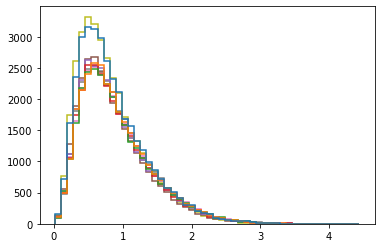

In [33]:
for i in range(len(bolt_err)):
    plt.hist(bolt_err[i], bins = 50, histtype='step', lw = 1.5, label="Ring"+str(i))
    plt.title("Bolt position error, avg. = "+str(np.average(bolt_err)))
    plt.xlabel("Distance from true to reco. position [cm]")
    plt.legend()
    
plt.figure()
for j in range(len(centre_err)):
    plt.hist(centre_err[i], bins = 50, histtype='step', lw = 1.5, label="Ring"+str(j))
    plt.title("Bolt ring centre position error, avg. = "+str(np.average(centre_err_means)))
    plt.xlabel("Distrance from true to reco. position [cm]")
    plt.legend()
    
plt.figure()
for k in range(len(orient_err)):
    plt.hist(orient_err[i], bins = 50, histtype='step', lw = 1.5, label="Ring"+str(k))
    plt.title("Ring orientation error, avg. = "+str(np.average(orient_err_means)))
    plt.xlabel("Angle between true and reco. orientation [\deg]")
    plt.legend()

In [2]:
print("Number of features in each ring: ", len(transform_arr[0]), ", ",len(transform_arr[1]), ", ", len(transform_arr[2]), ", ", len(transform_arr[3]), ", ", len(transform_arr[4]), ", ", len(transform_arr[5]), ", ", len(transform_arr[6]), ", ", len(transform_arr[7]), ", ", len(transform_arr[8]), ", ", len(transform_arr[8]))
print(transform_arr[0])
count = 0
for i in range(len(transform_arr)):
    if i%2 == 0:
        print(min(transform_arr[i][:,2]))
        print(max(transform_arr[i][:,2]))
        if i > 0:
            print(abs(min(transform_arr[i][:,2]) - max(transform_arr[i-1][:,2])))
            print("")
        count+=1

print(len(transform_arr[0][:,0]))

NameError: name 'transform_arr' is not defined

In [24]:
print(focal_length)

[3110.7 3112.8]


Feature in image counts: Counter({8: 3421, 9: 523, 7: 318, 6: 160, 5: 20})


C:\Users\gaurr\OneDrive - TRIUMF\Hyper-K\Reconstruction\PhotogrammetryAnalysis-master\pg_fitter_tools.py:244: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


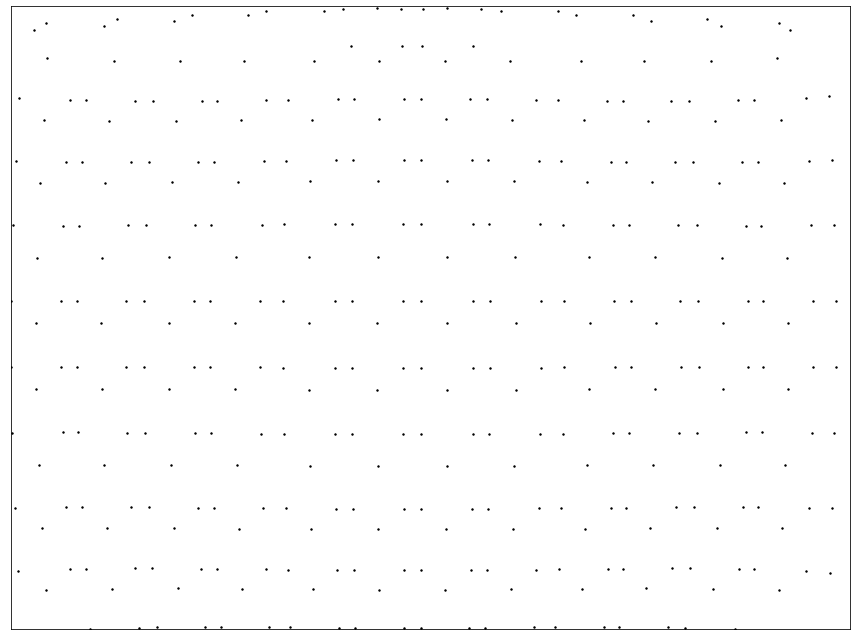

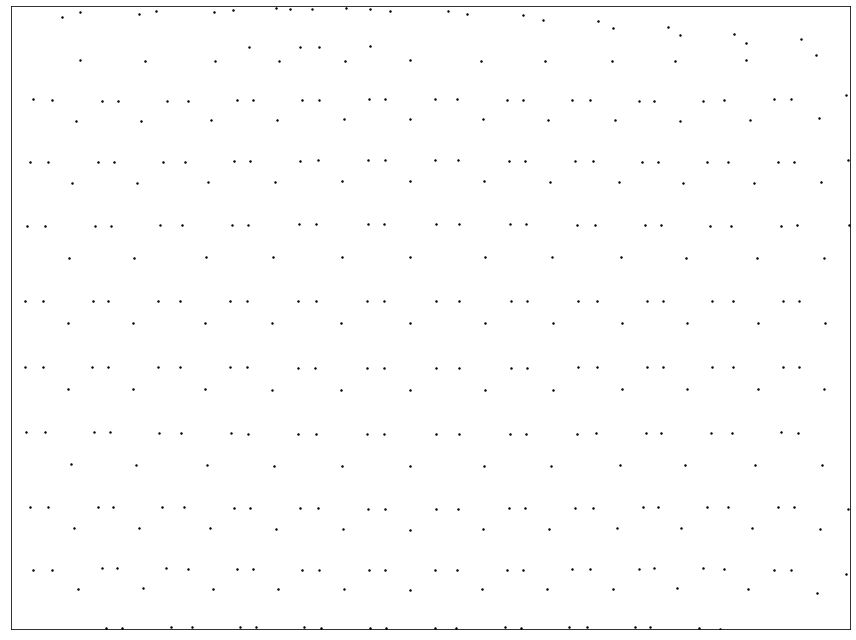

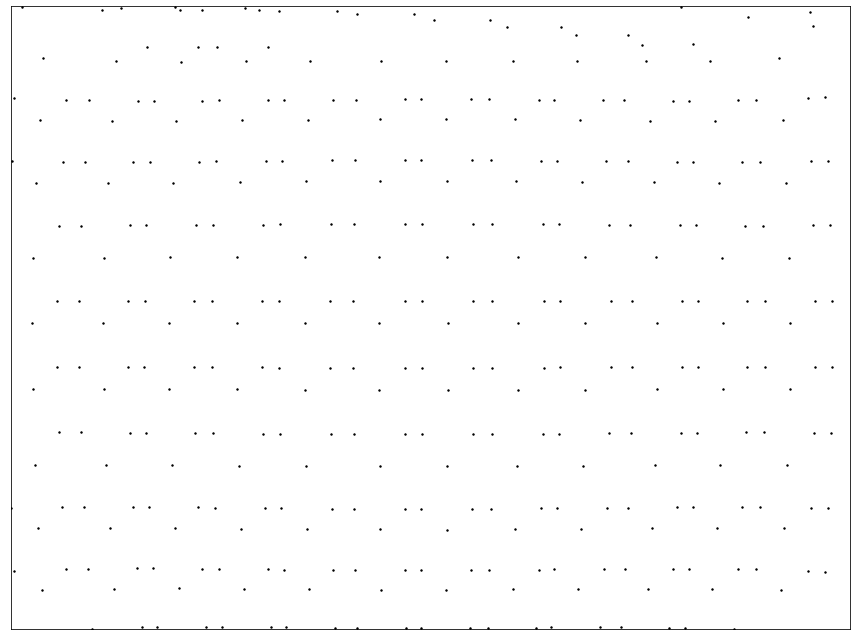

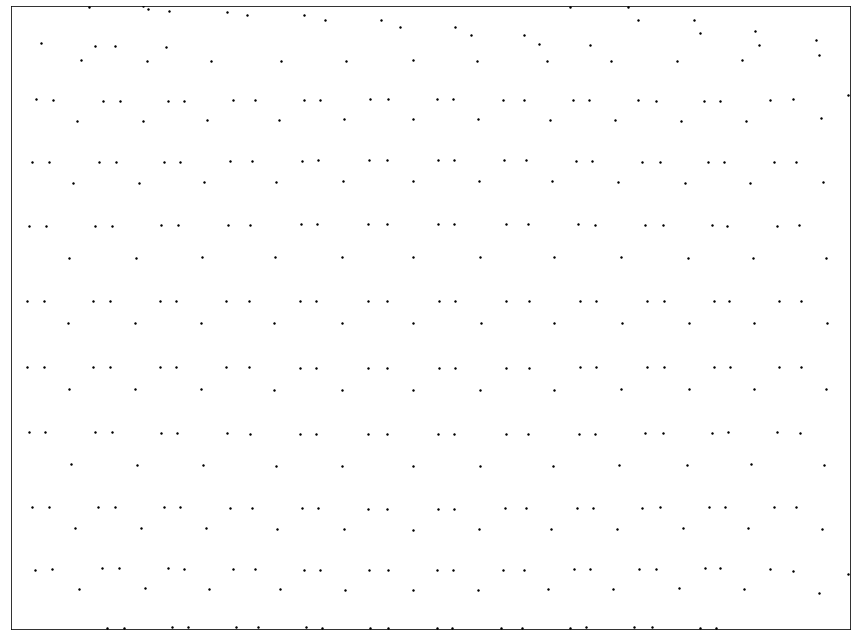

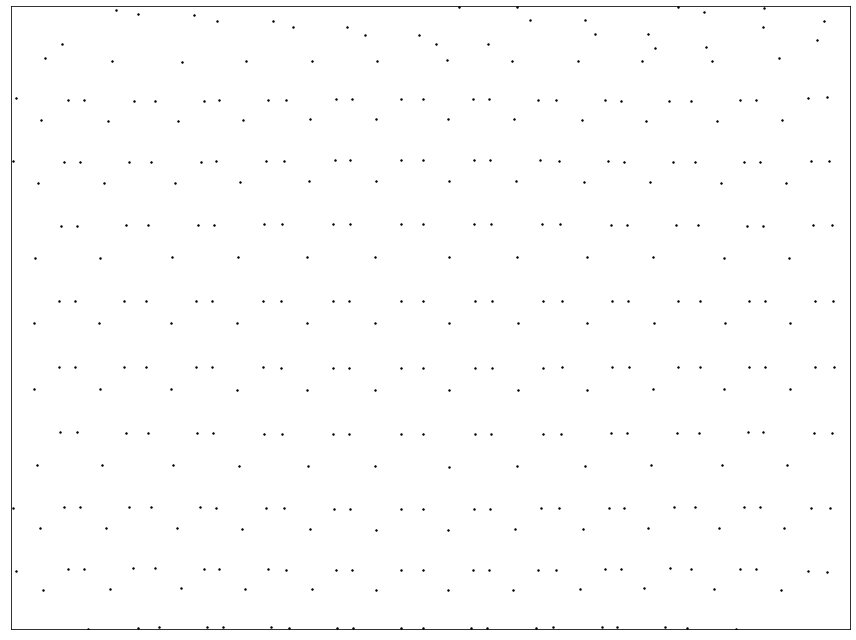

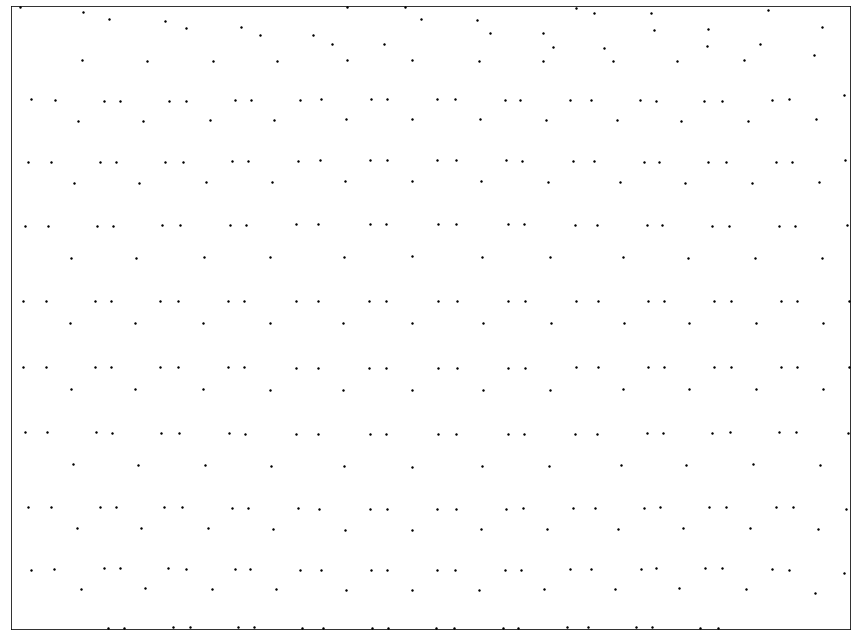

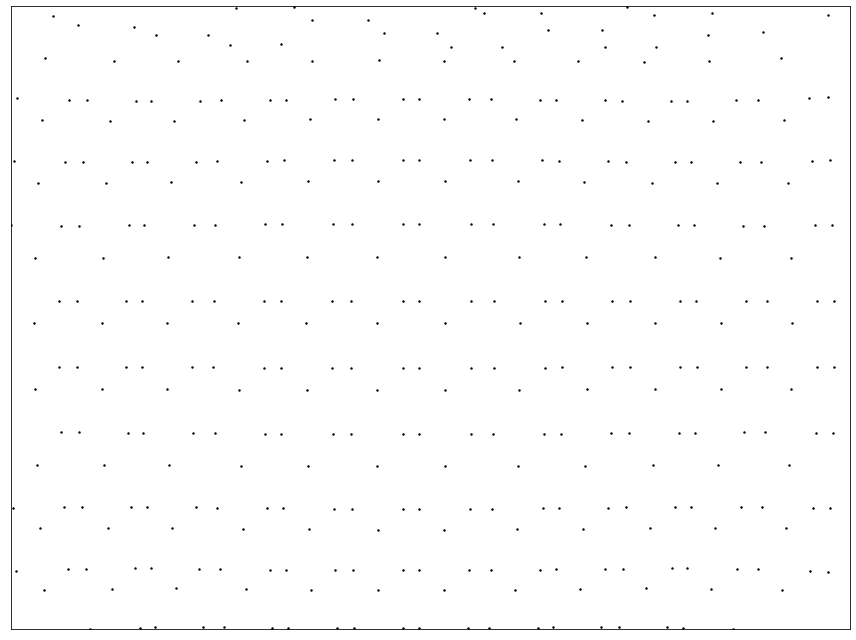

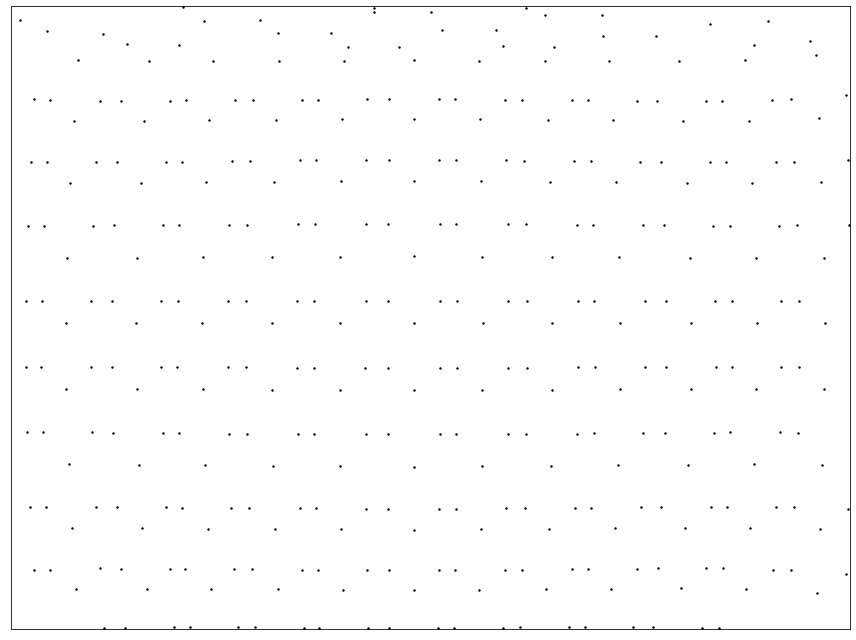

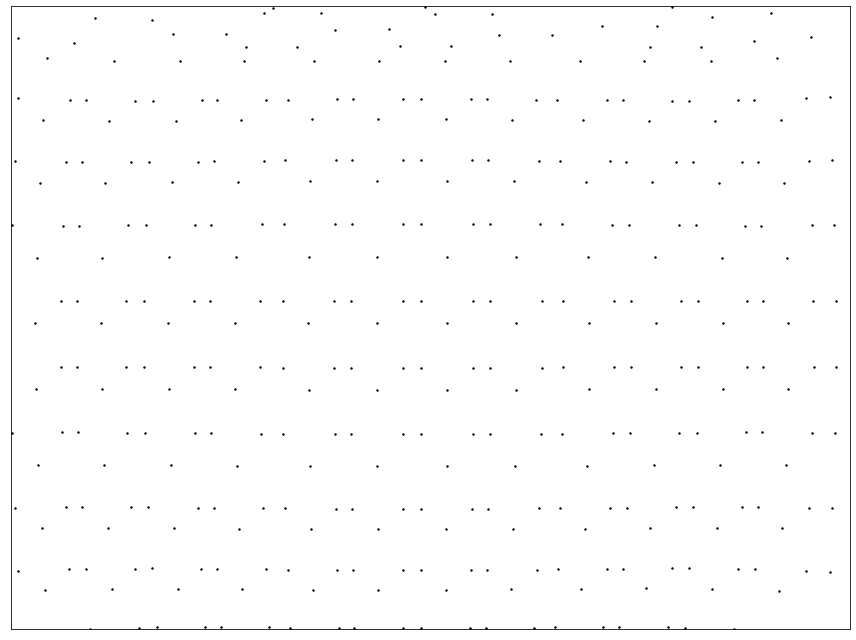

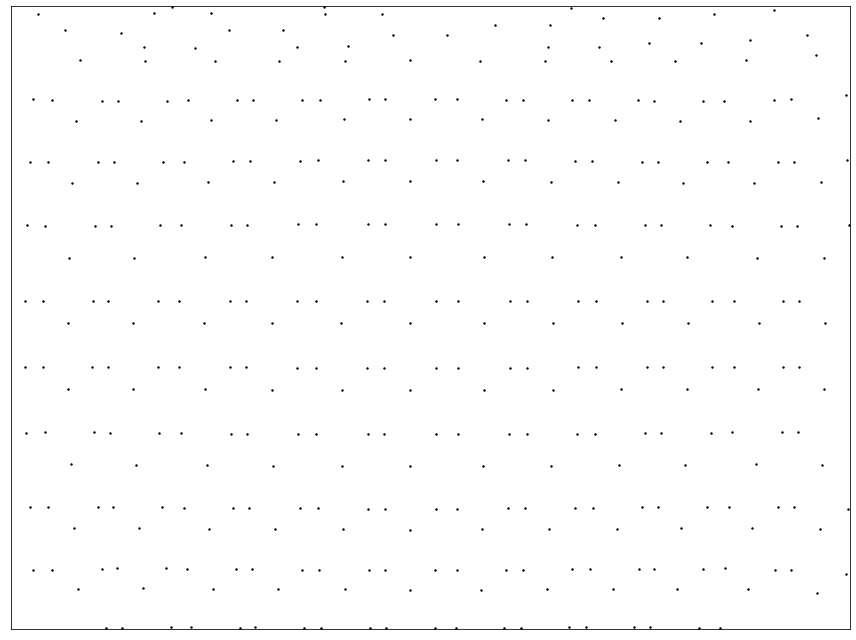

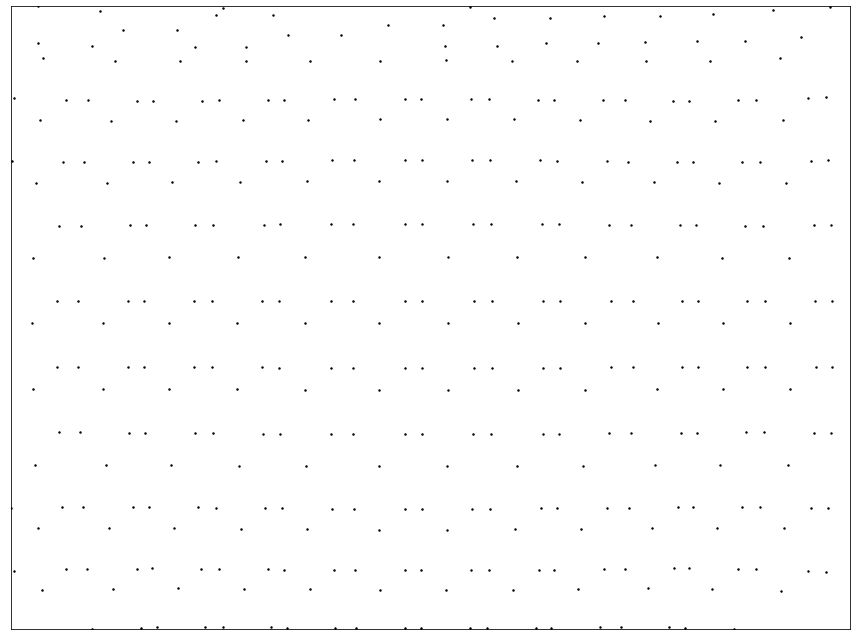

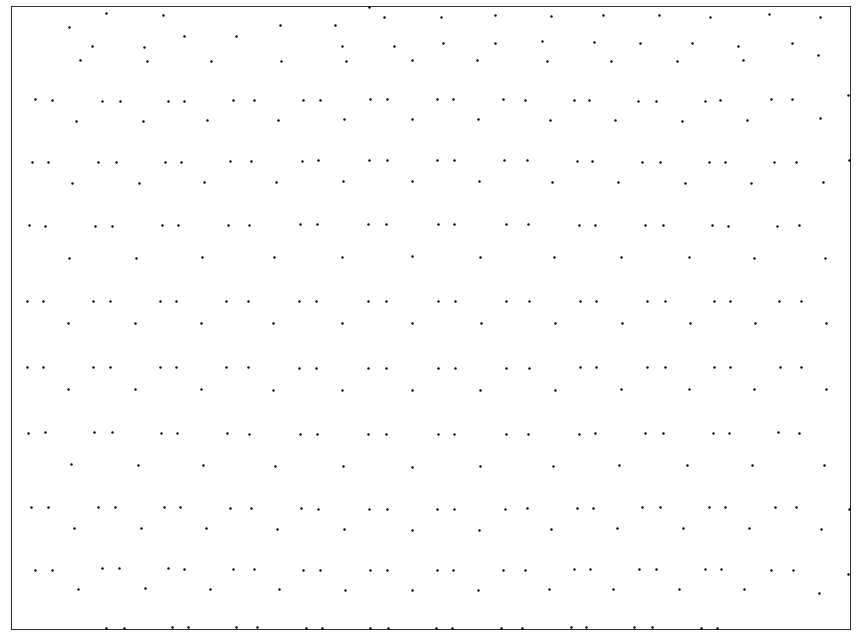

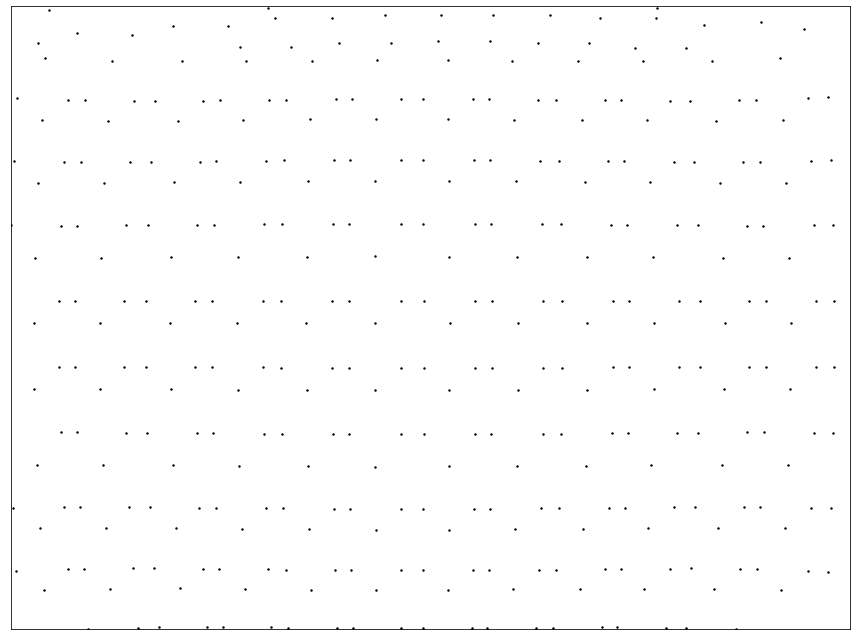

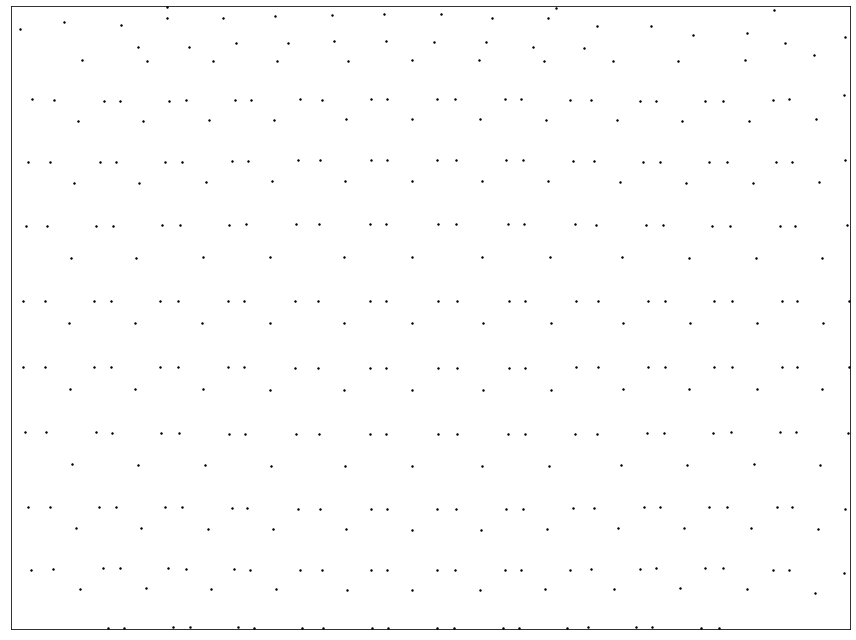

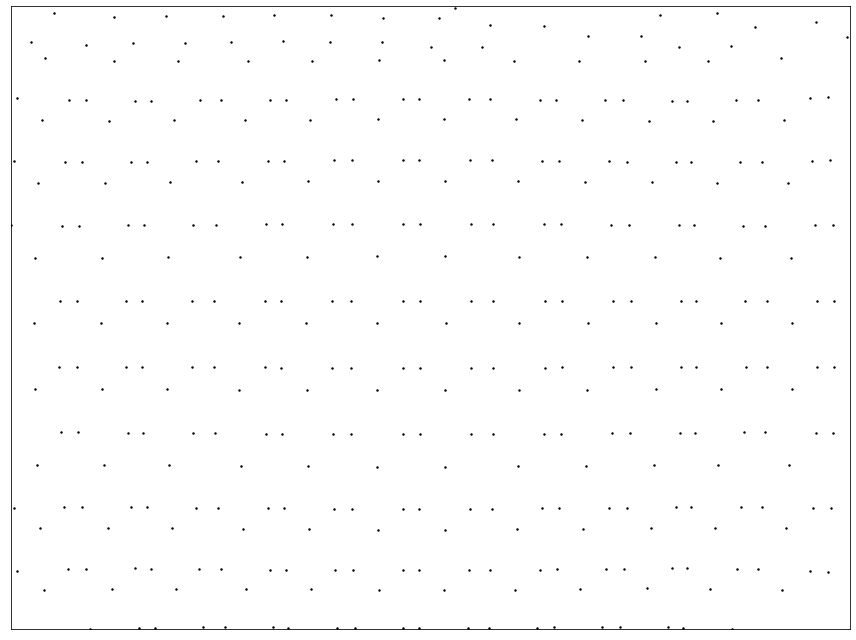

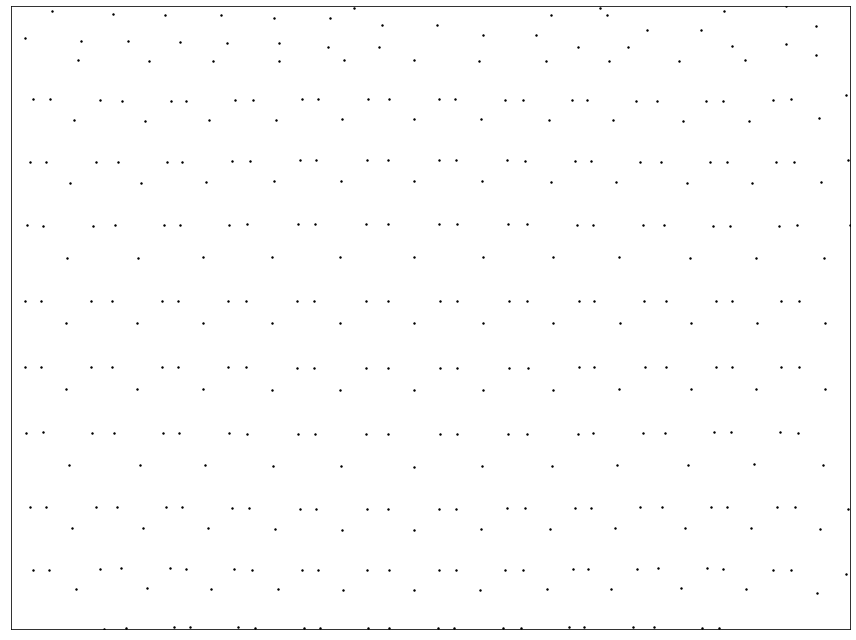

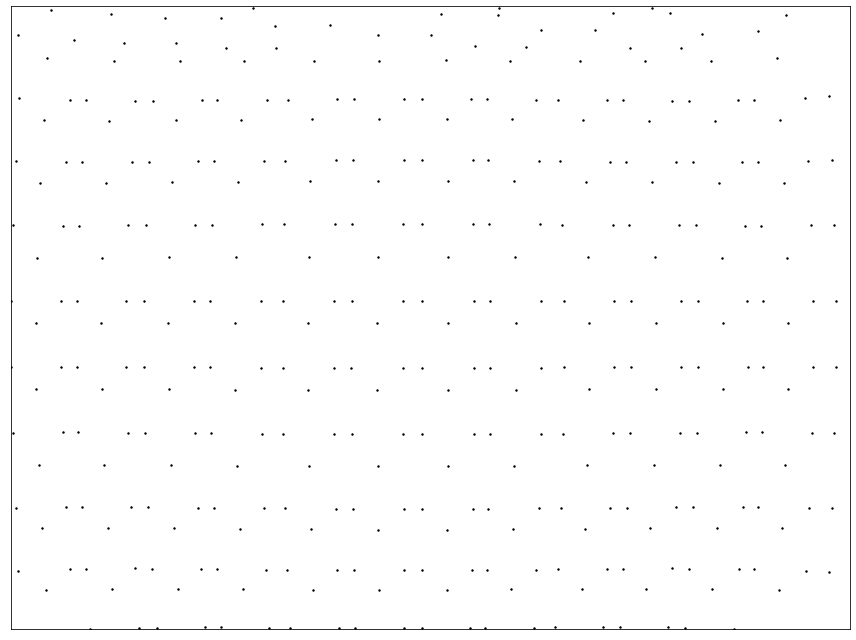

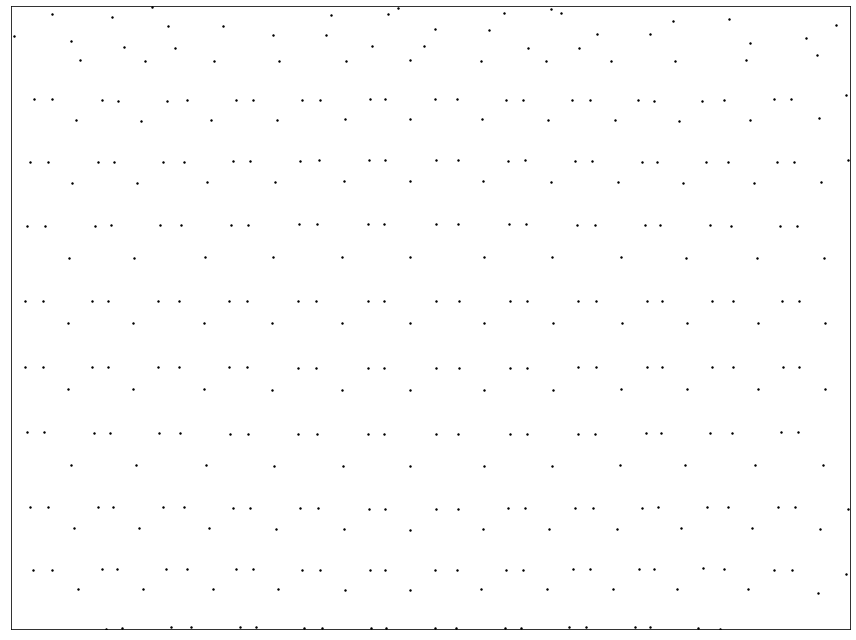

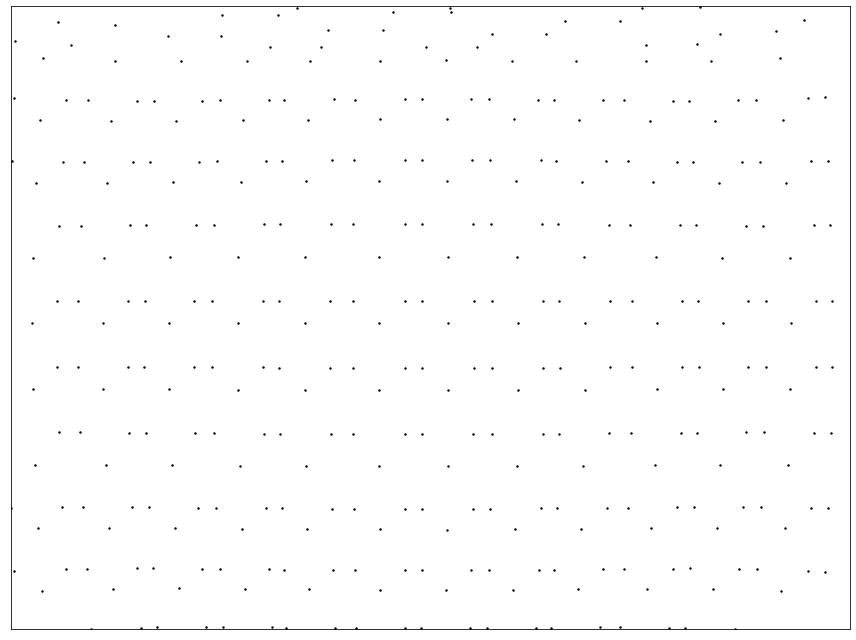

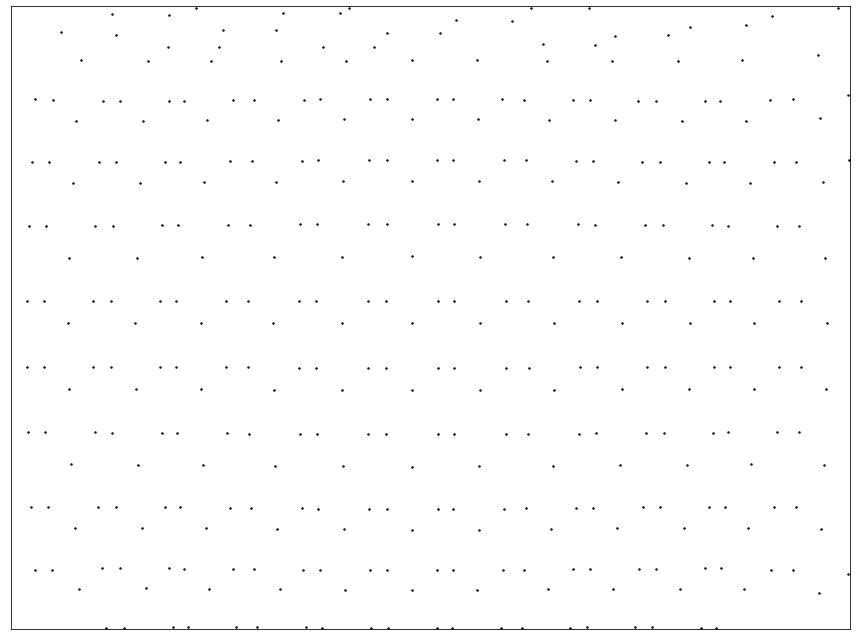

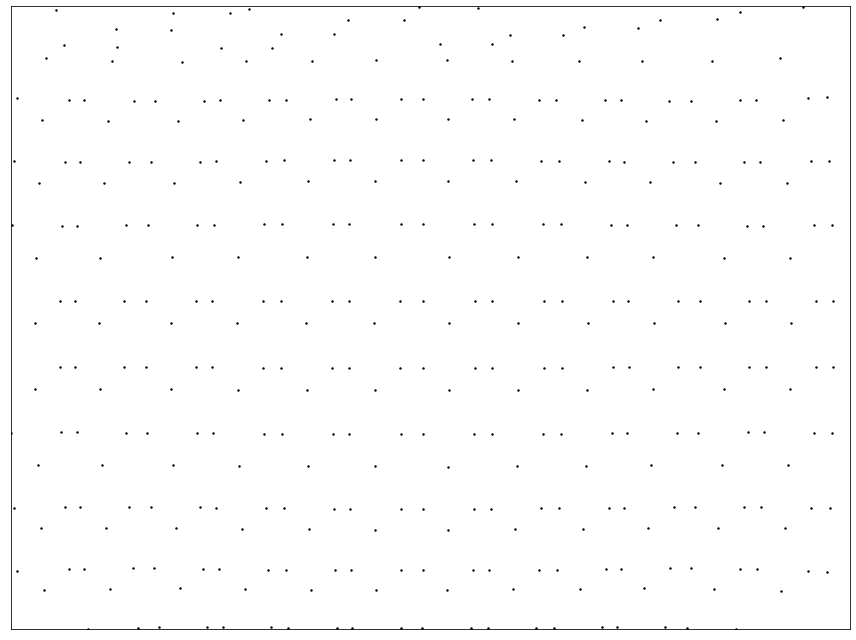

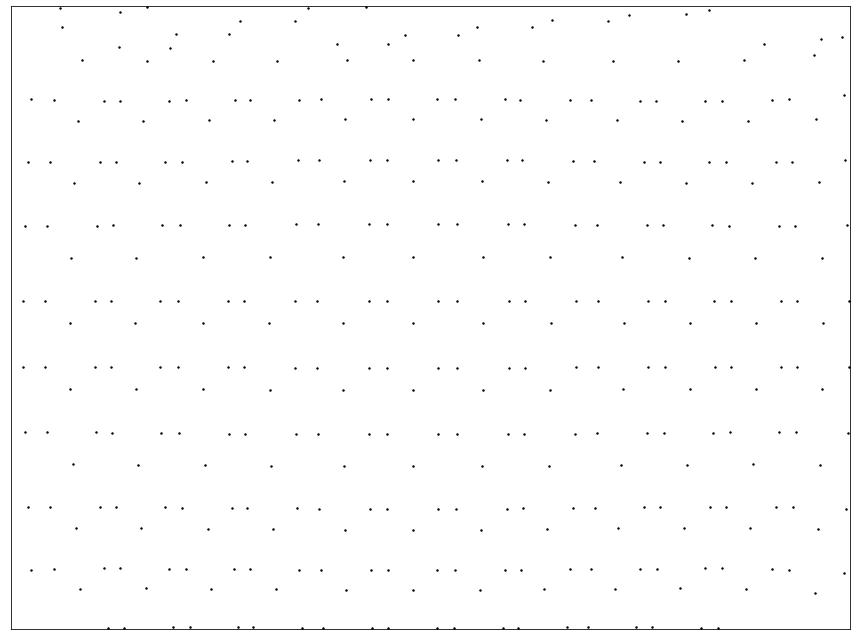

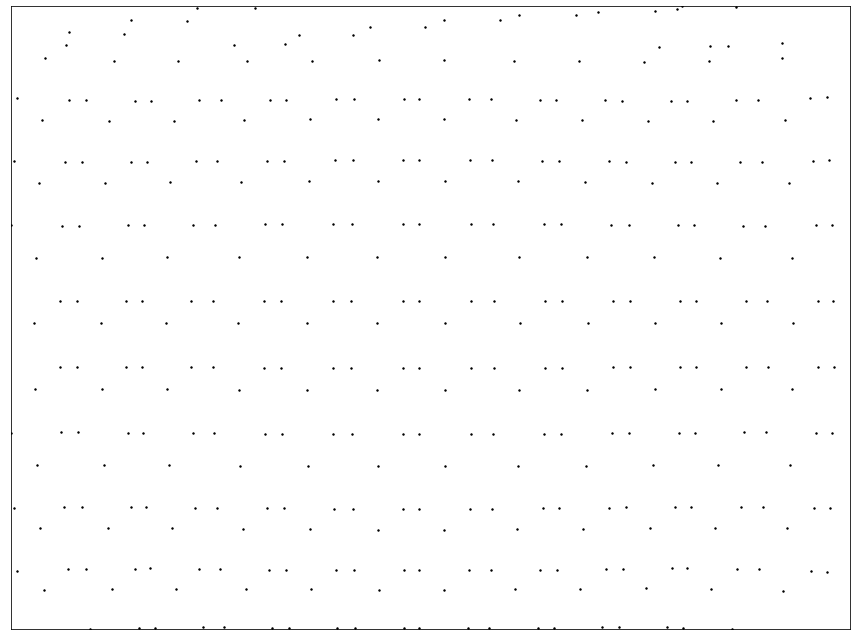

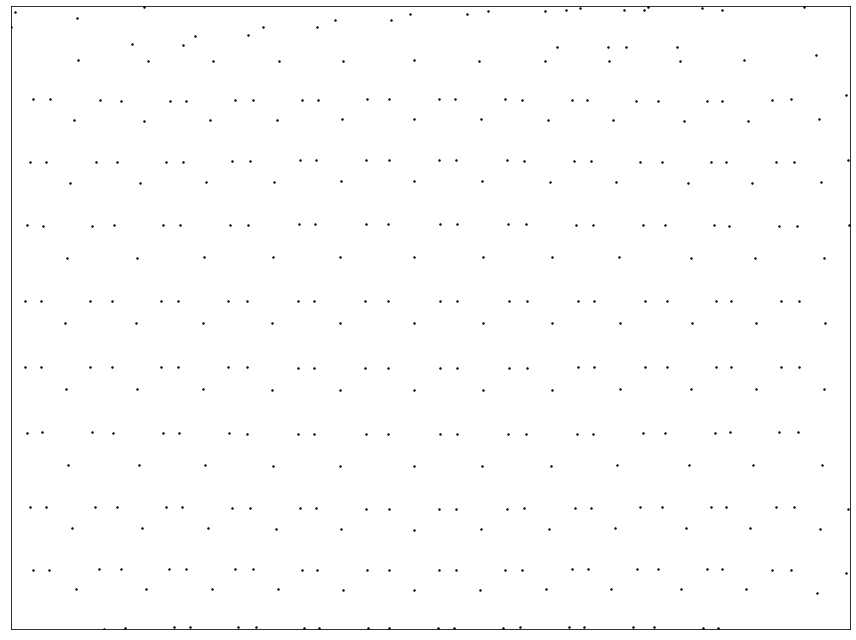

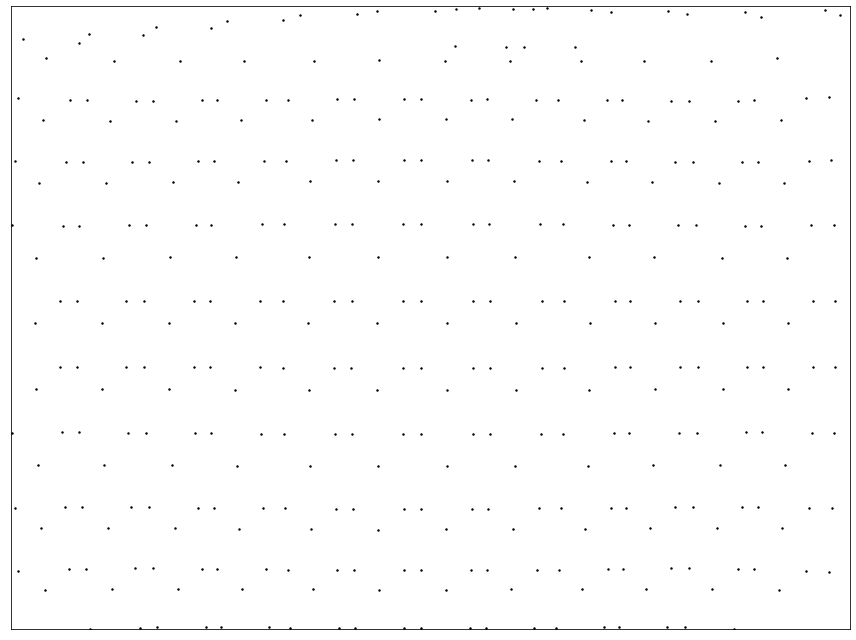

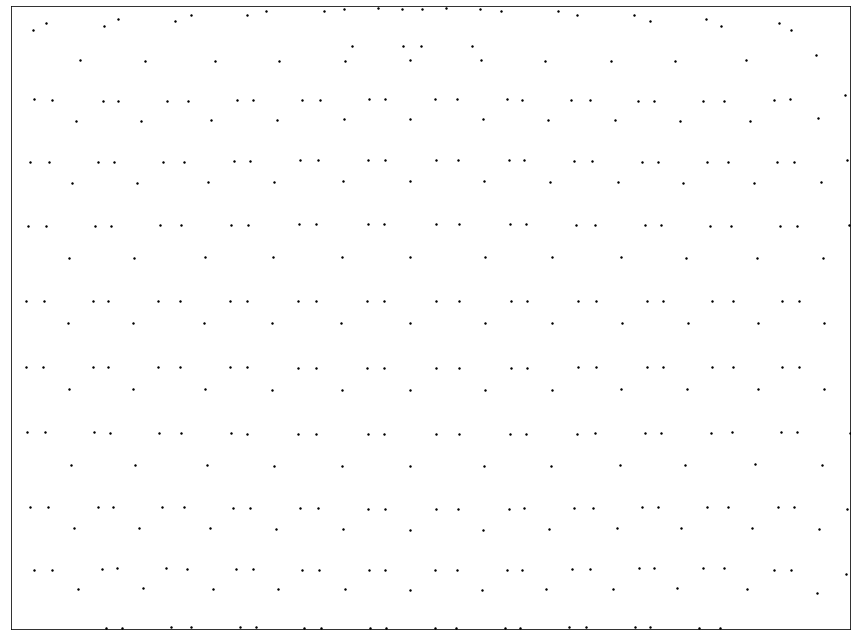

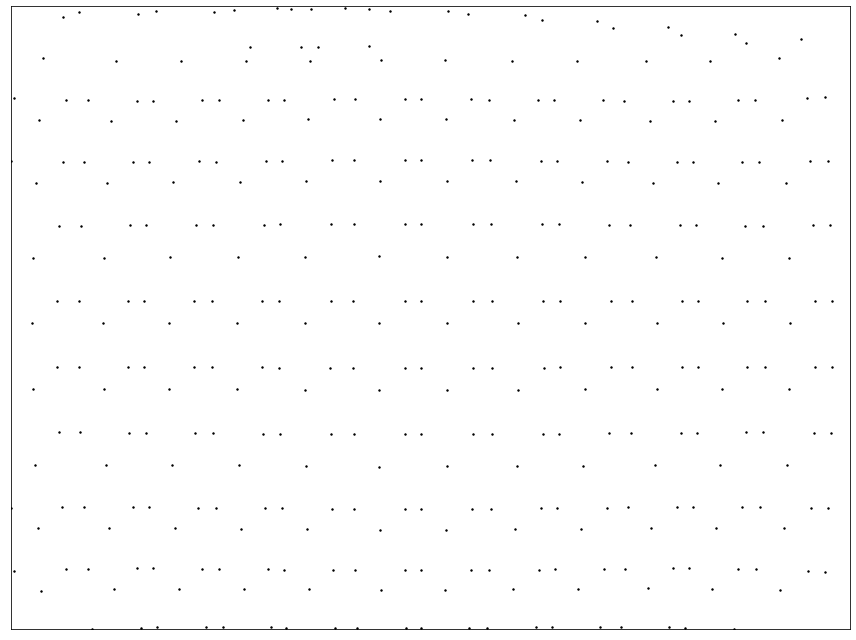

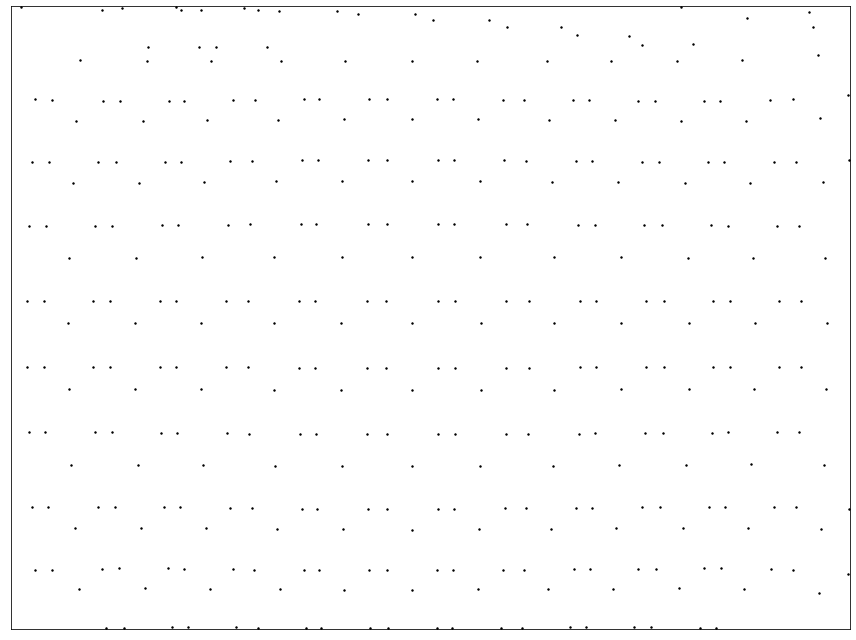

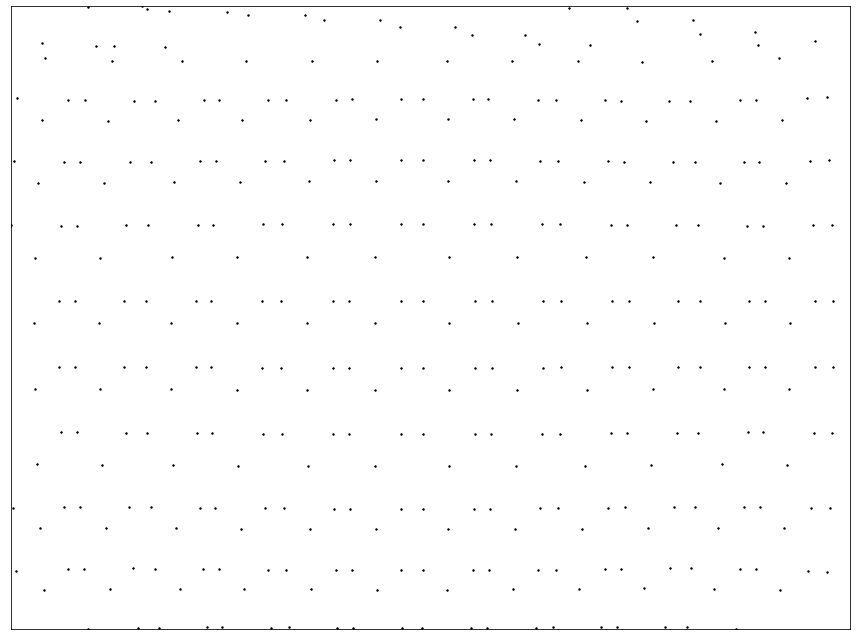

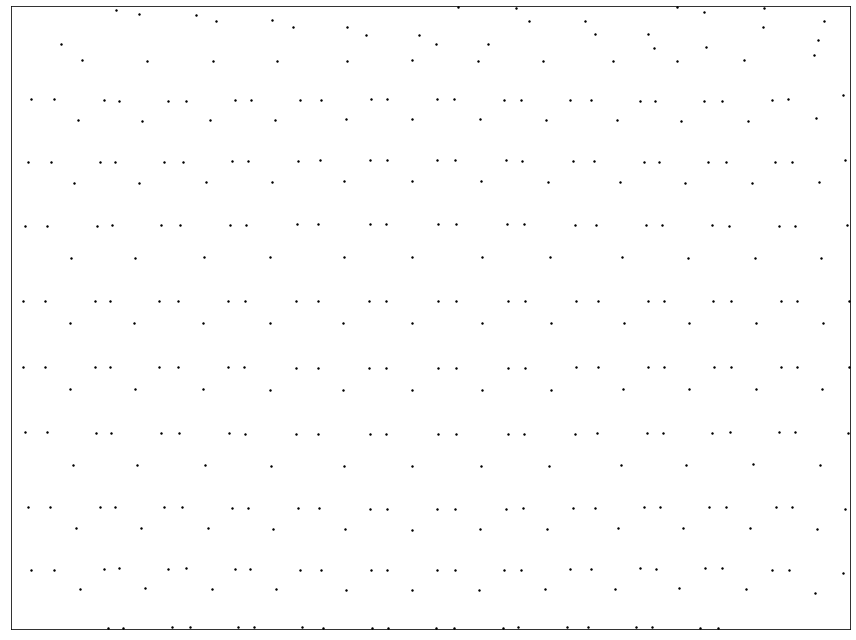

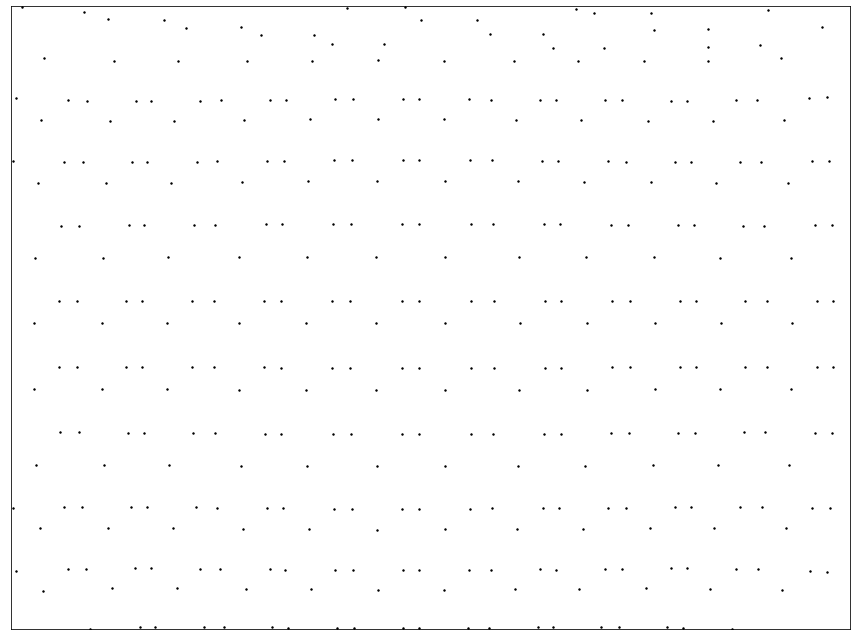

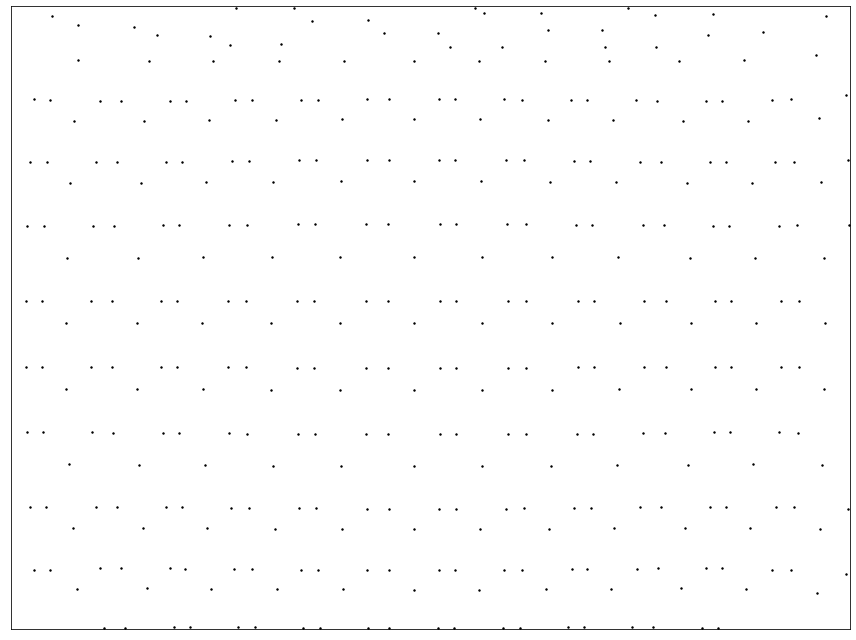

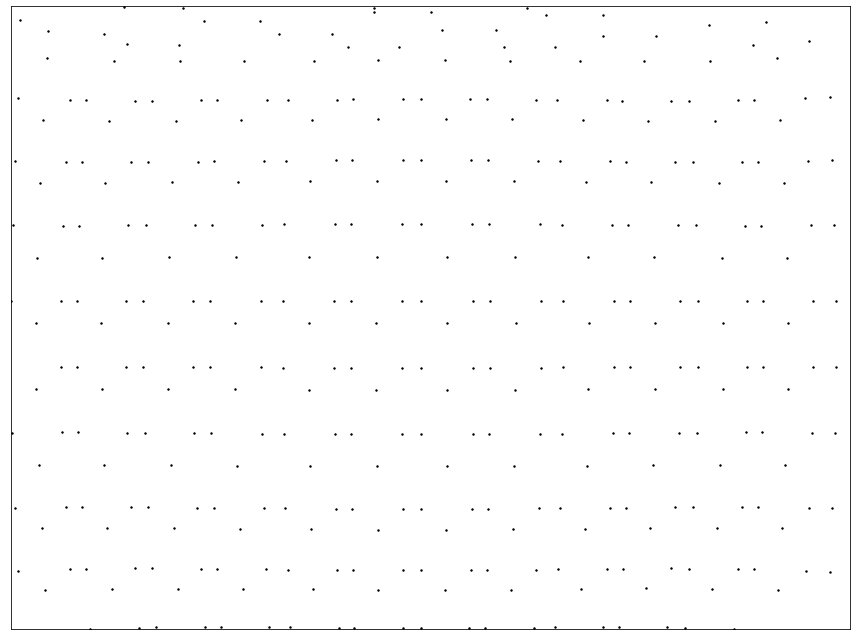

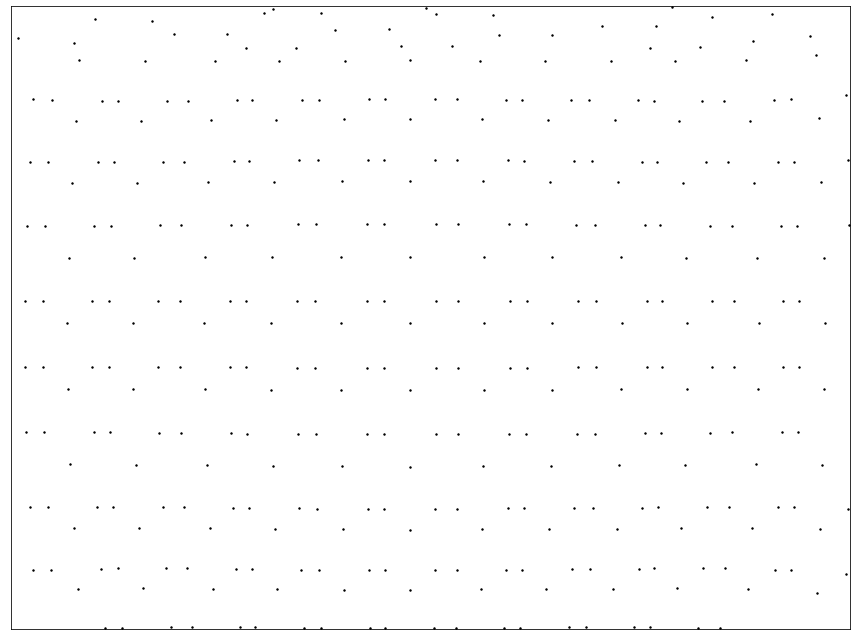

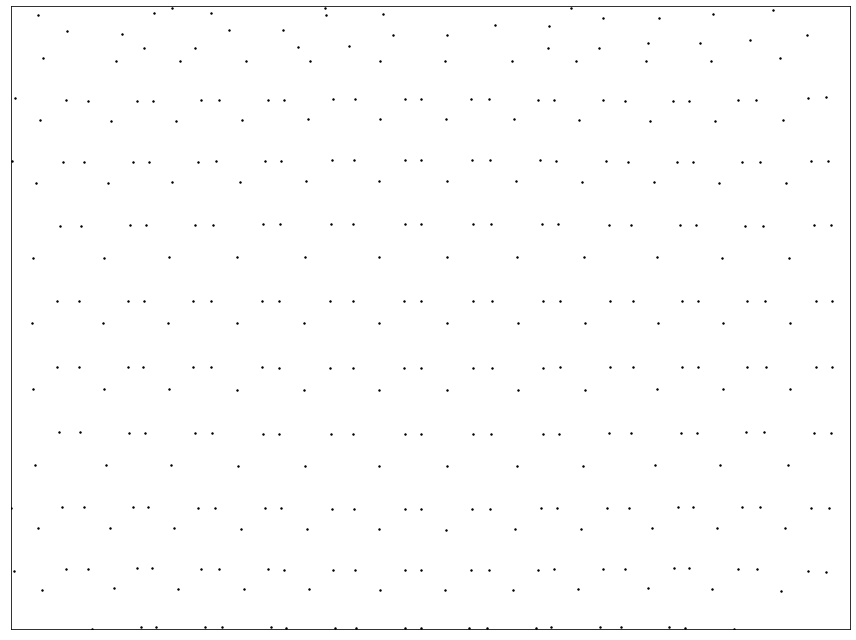

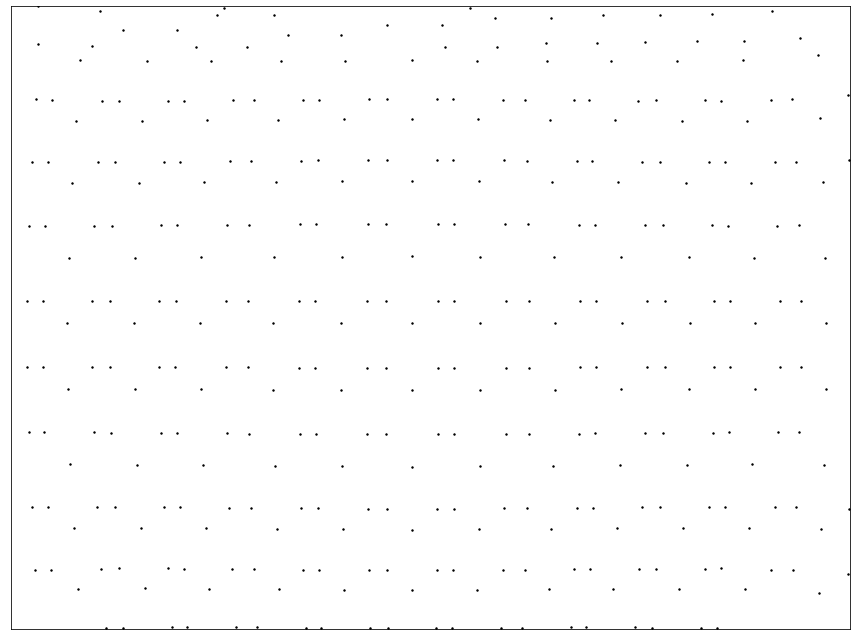

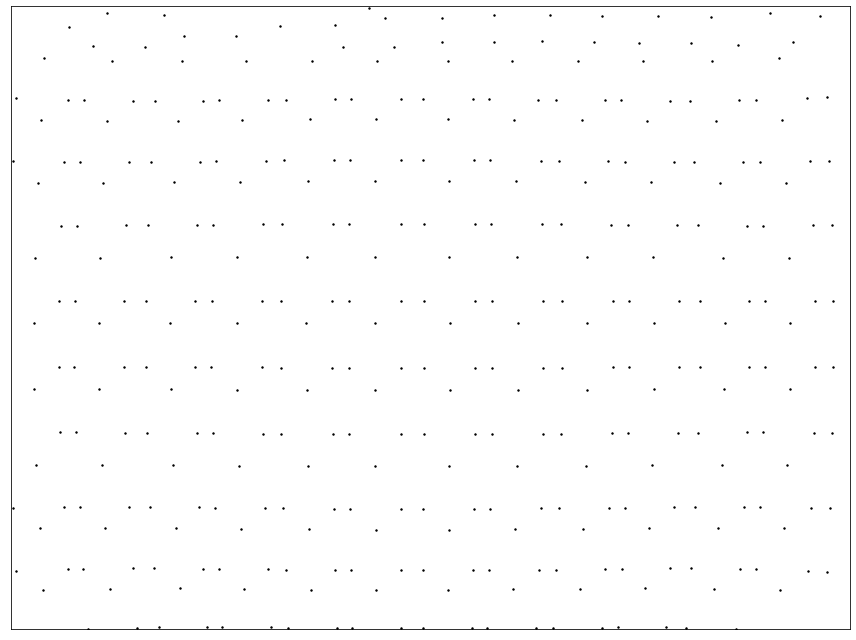

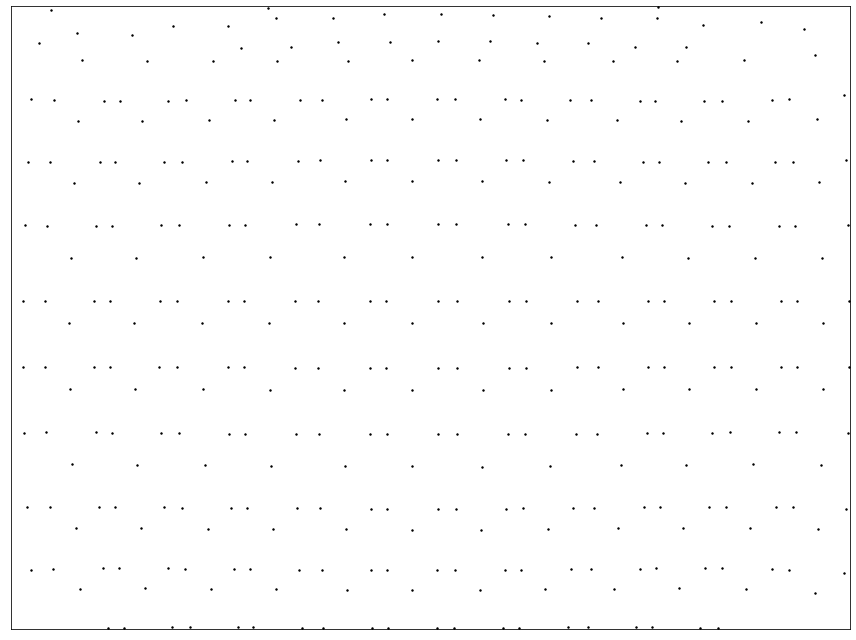

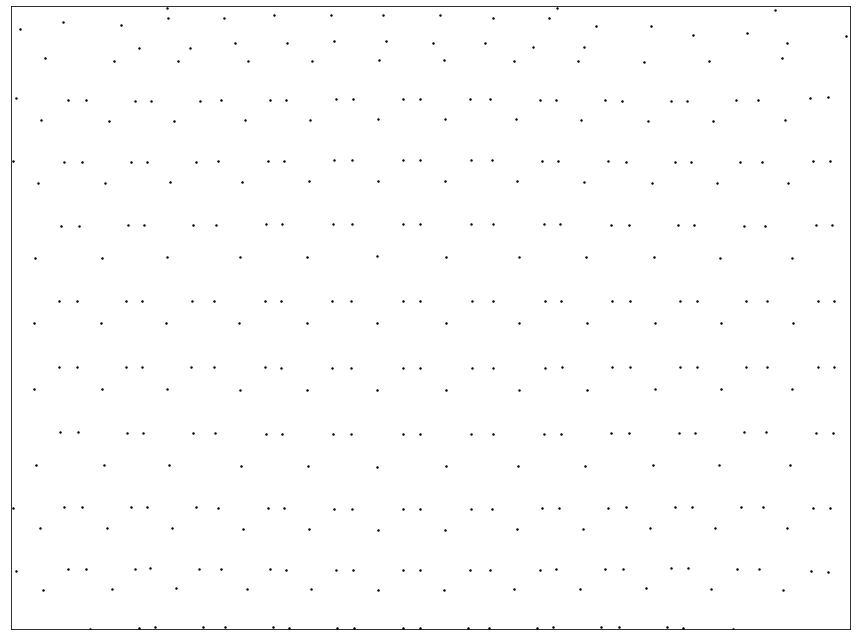

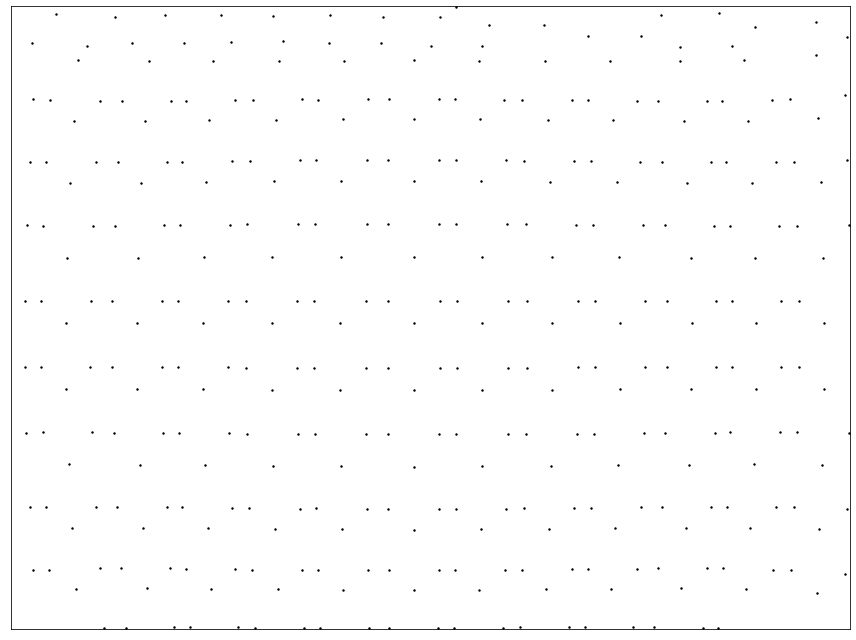

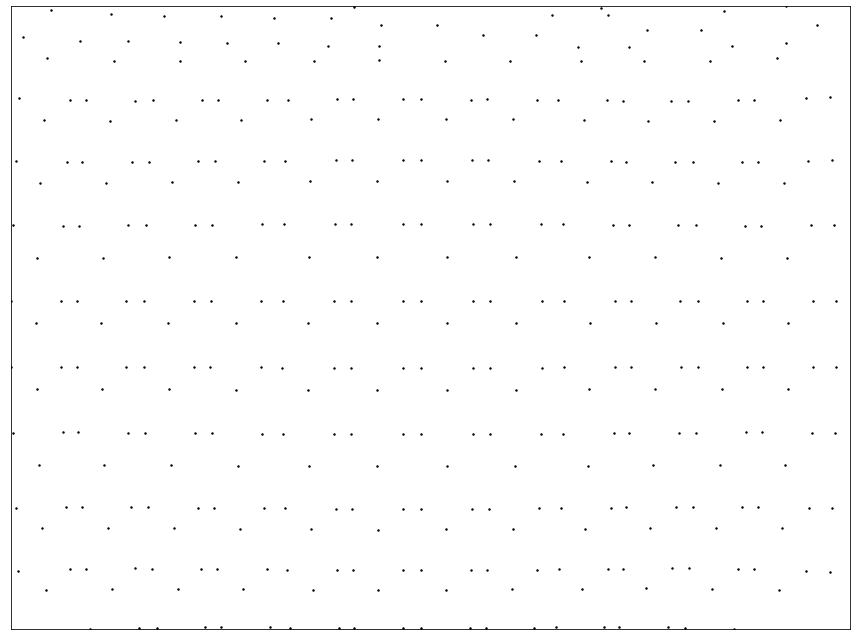

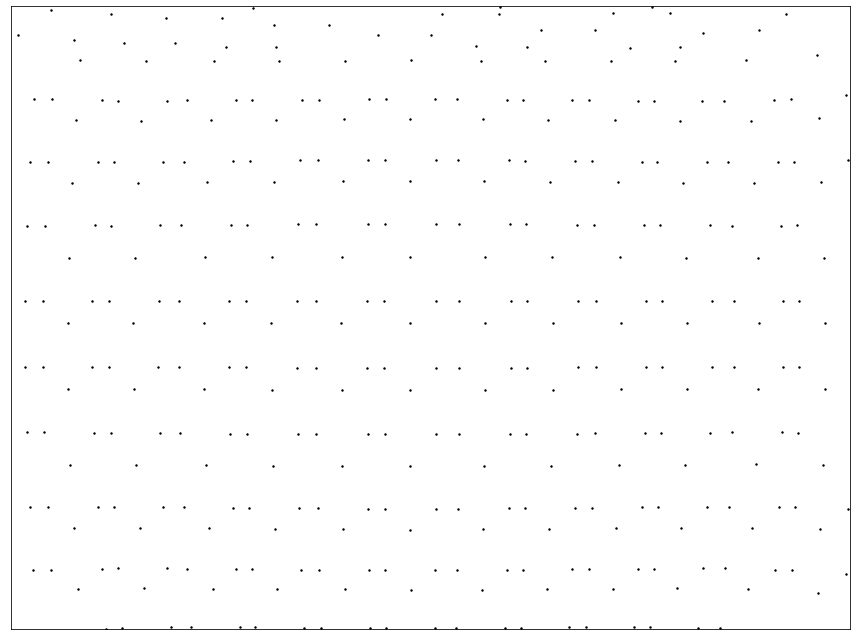

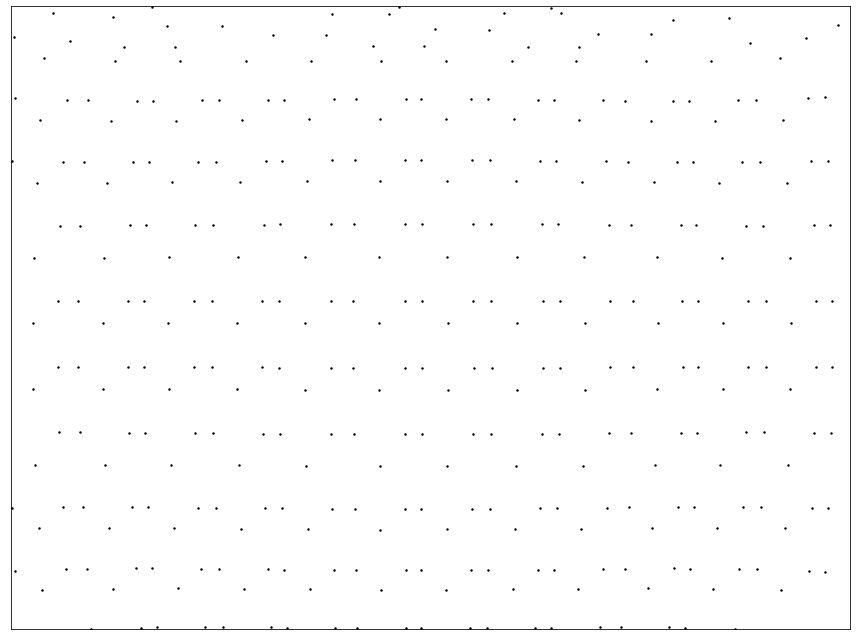

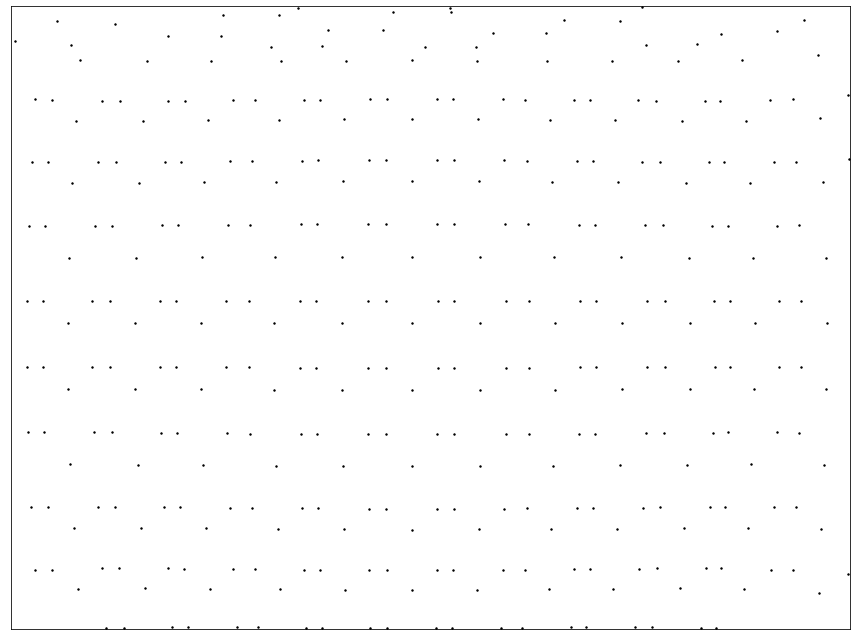

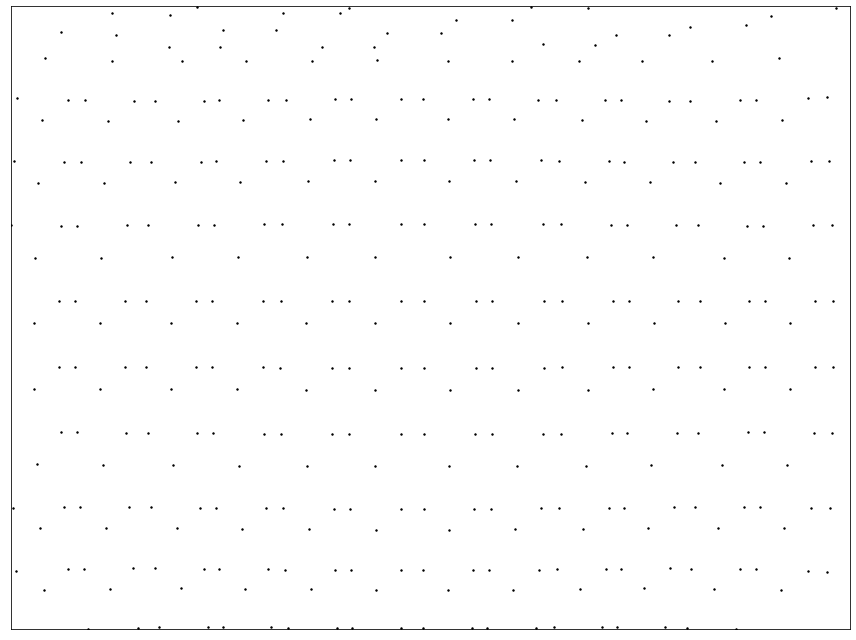

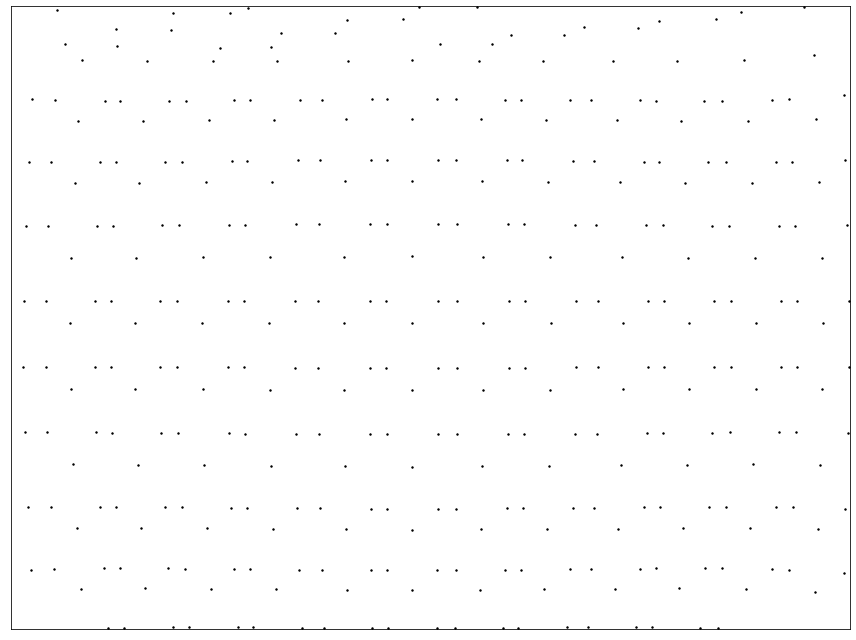

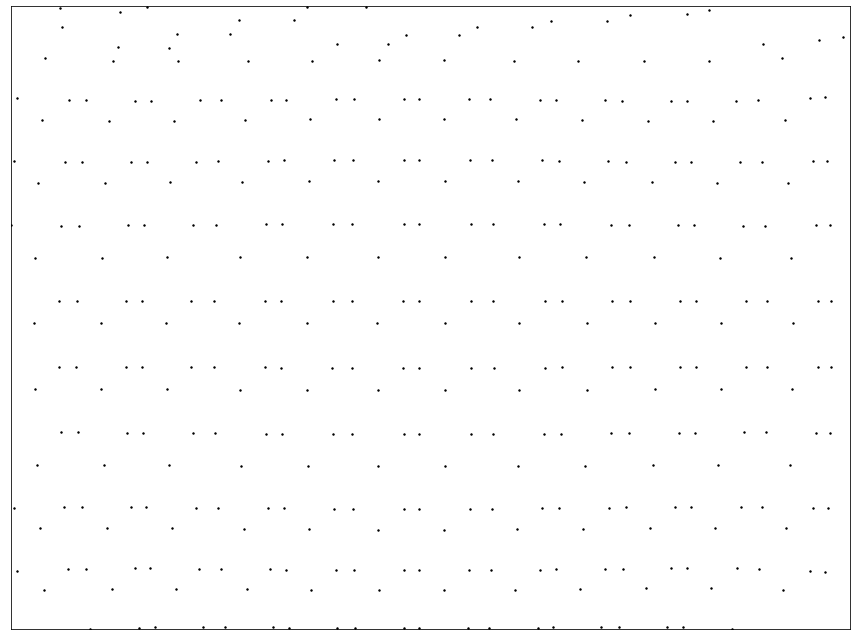

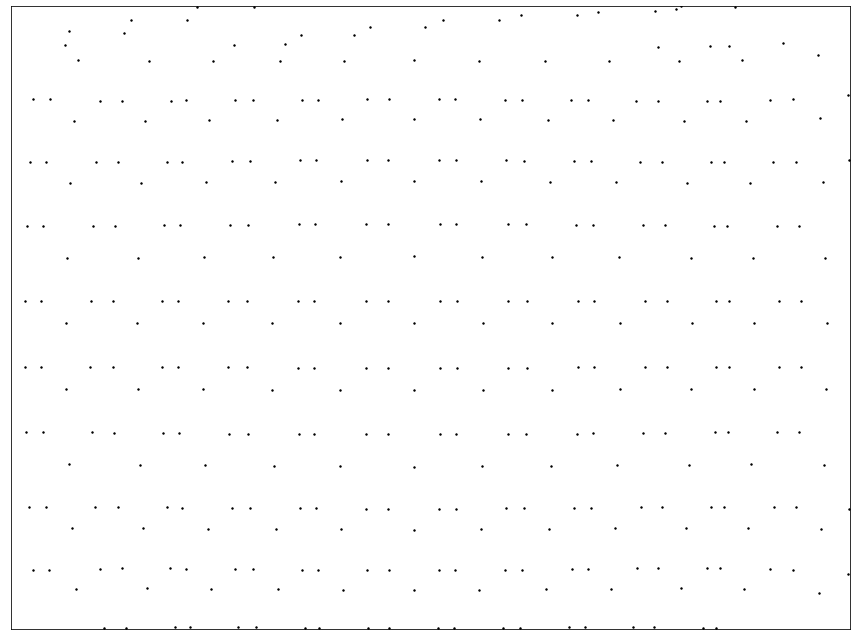

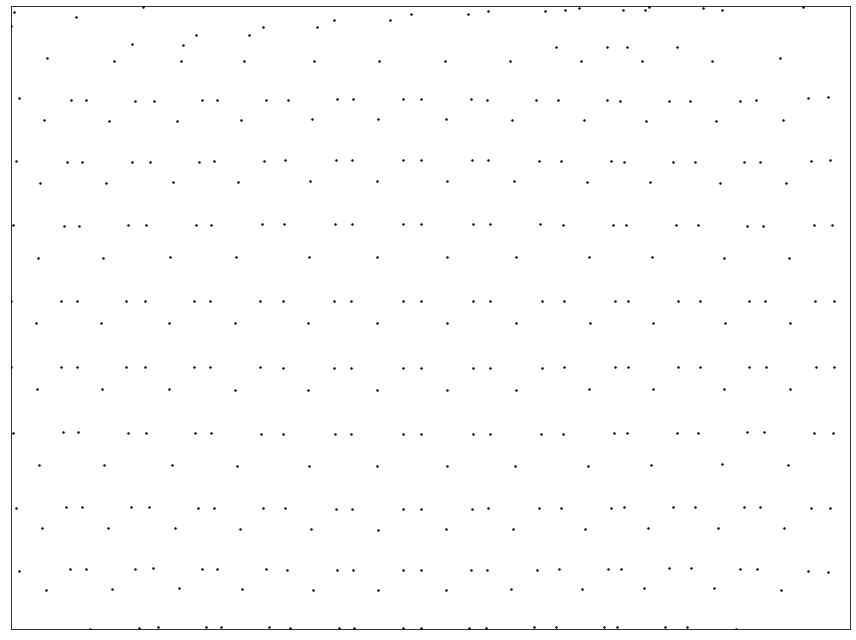

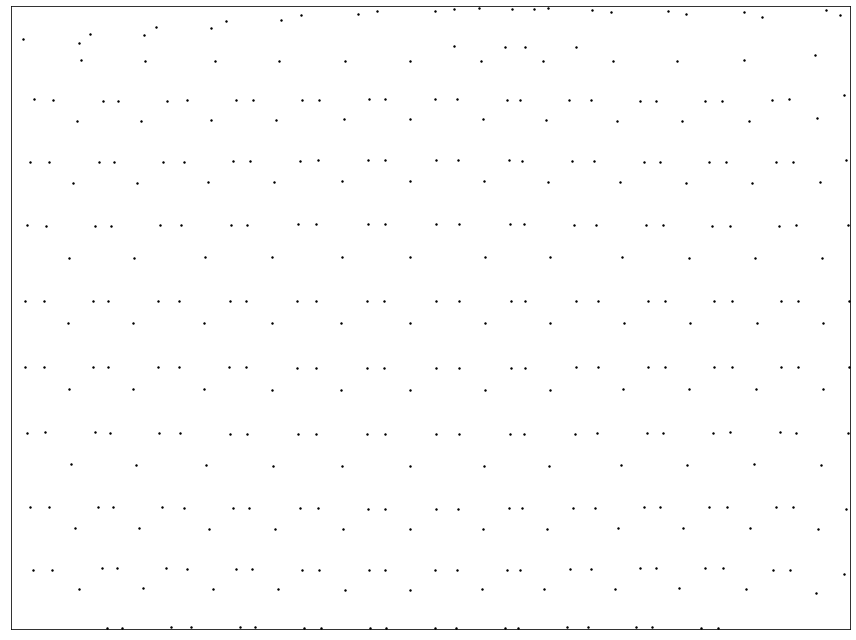

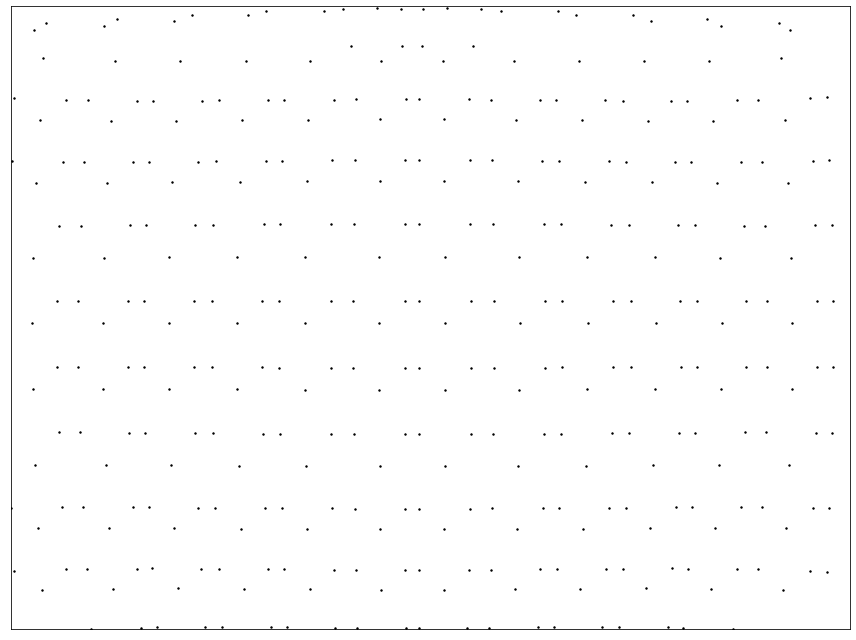

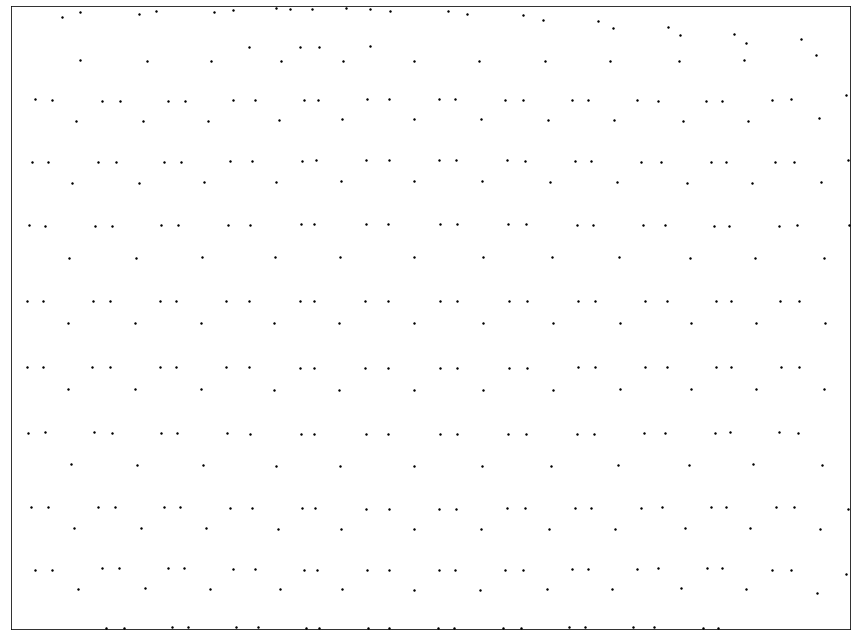

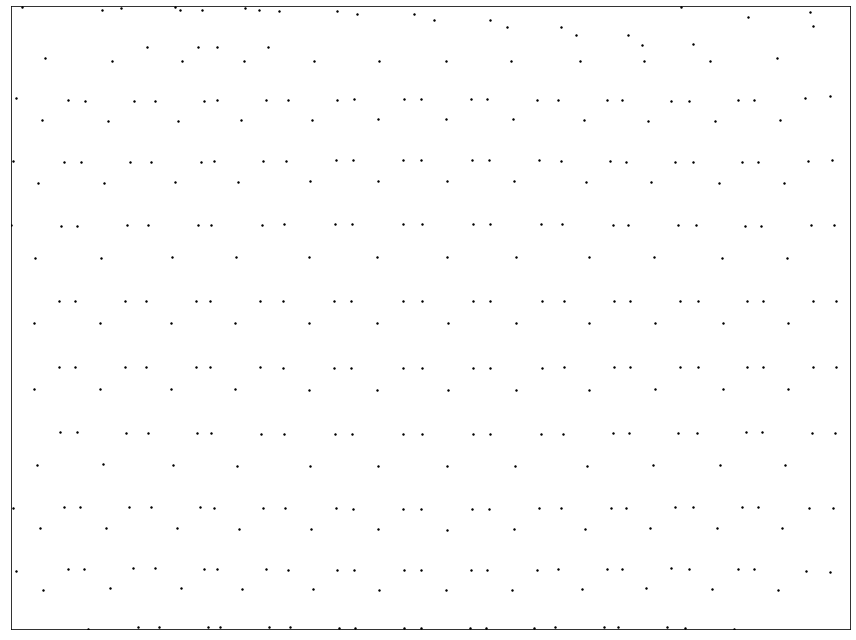

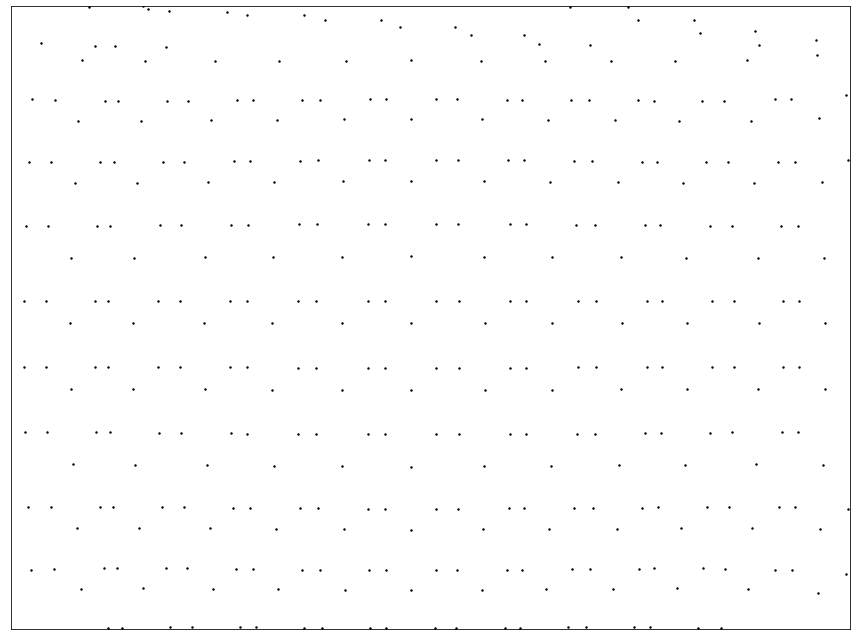

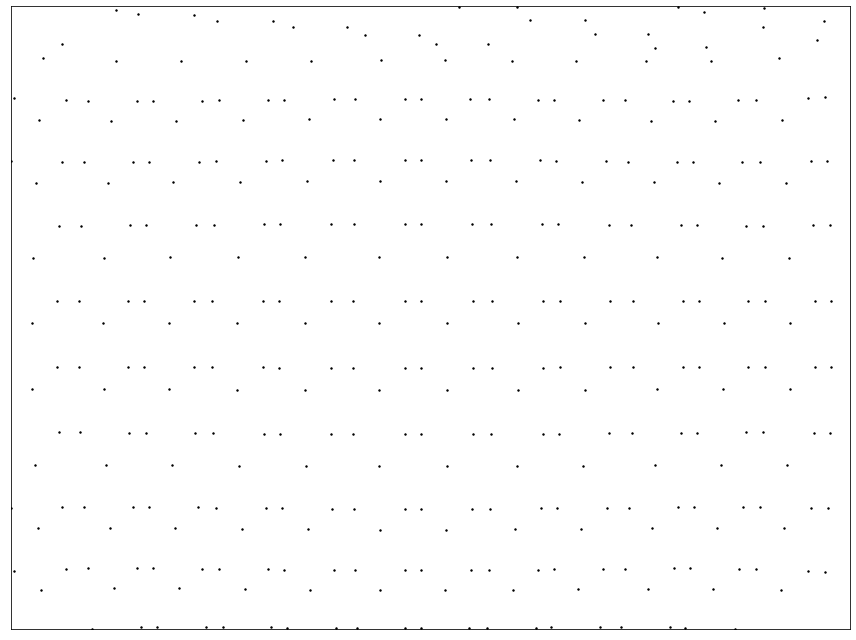

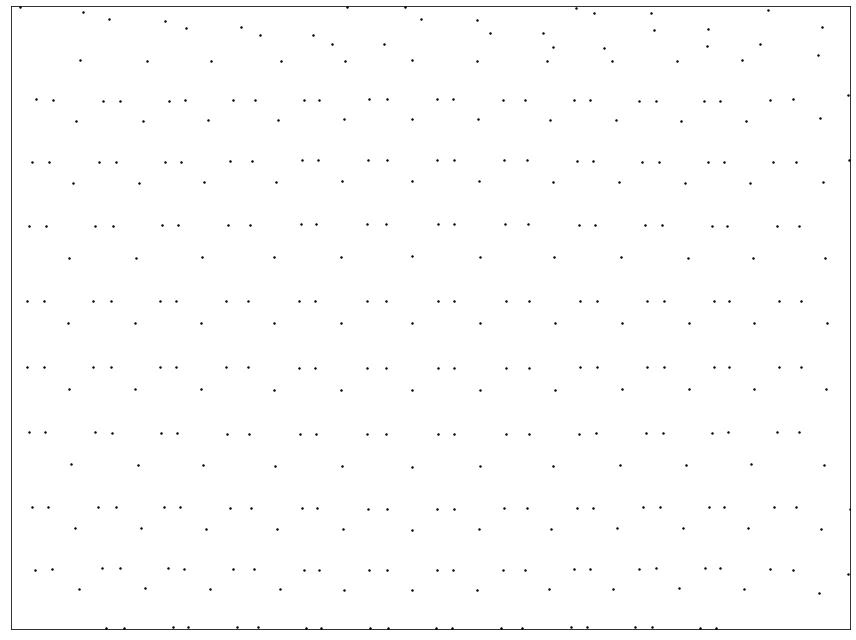

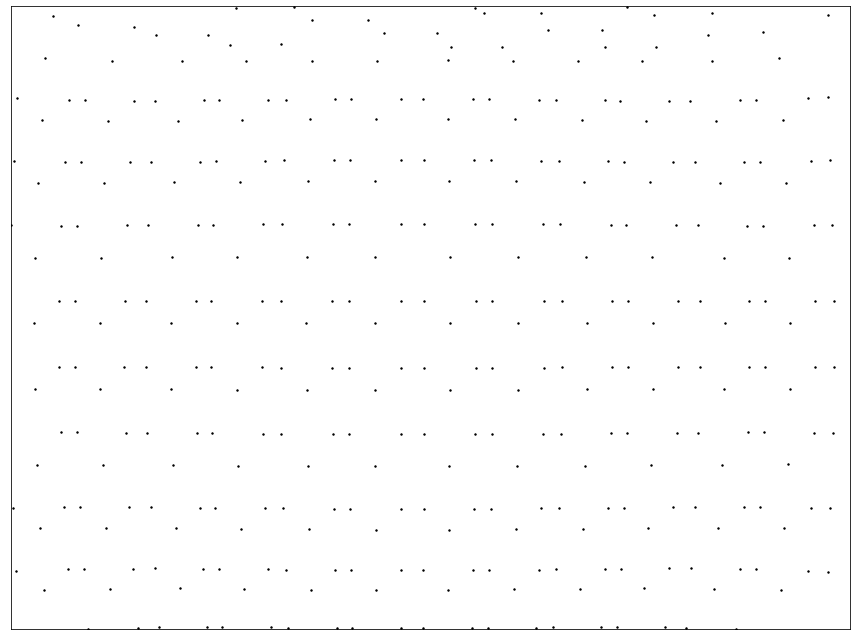

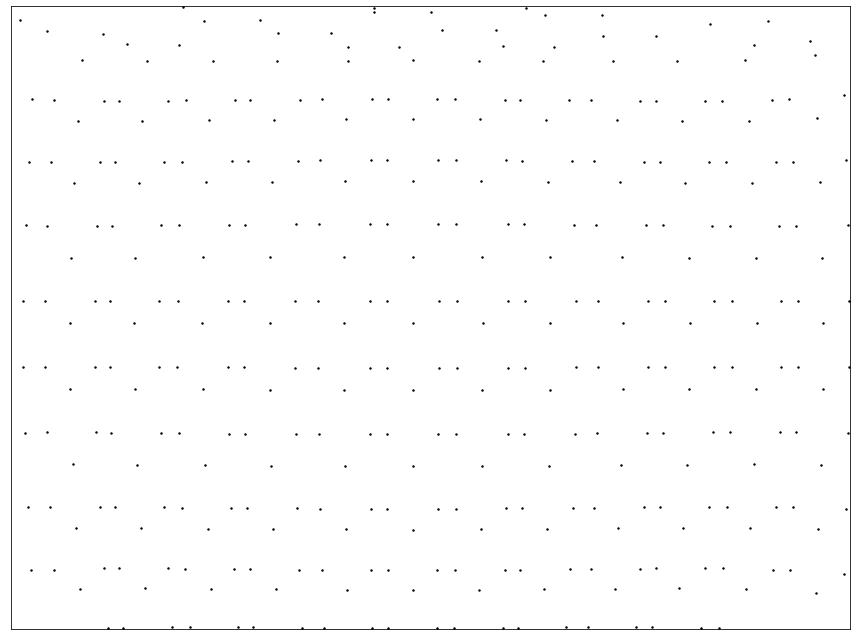

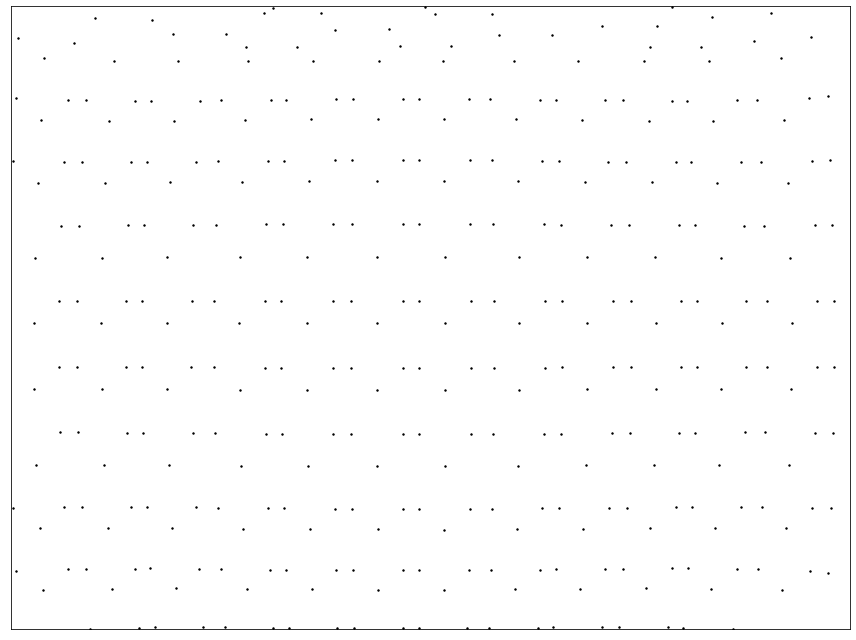

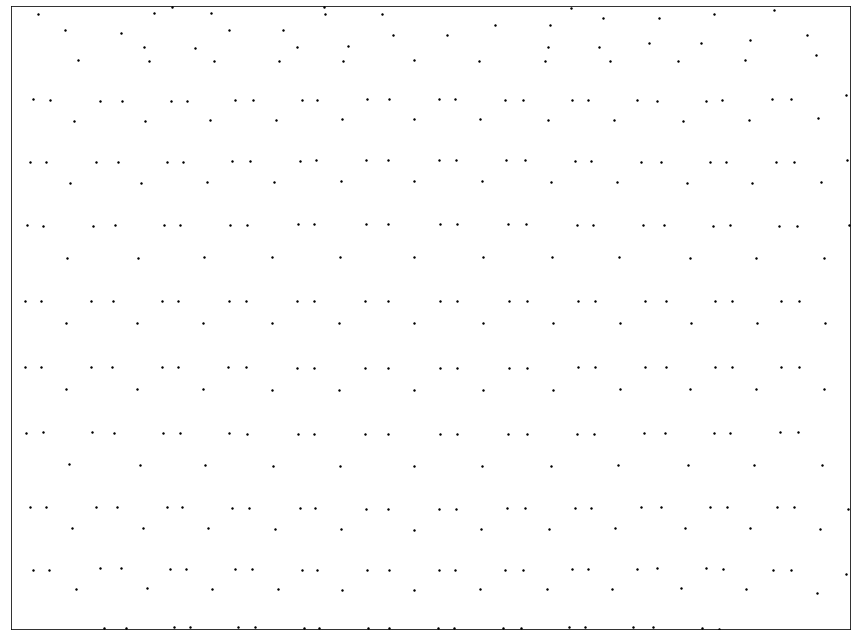

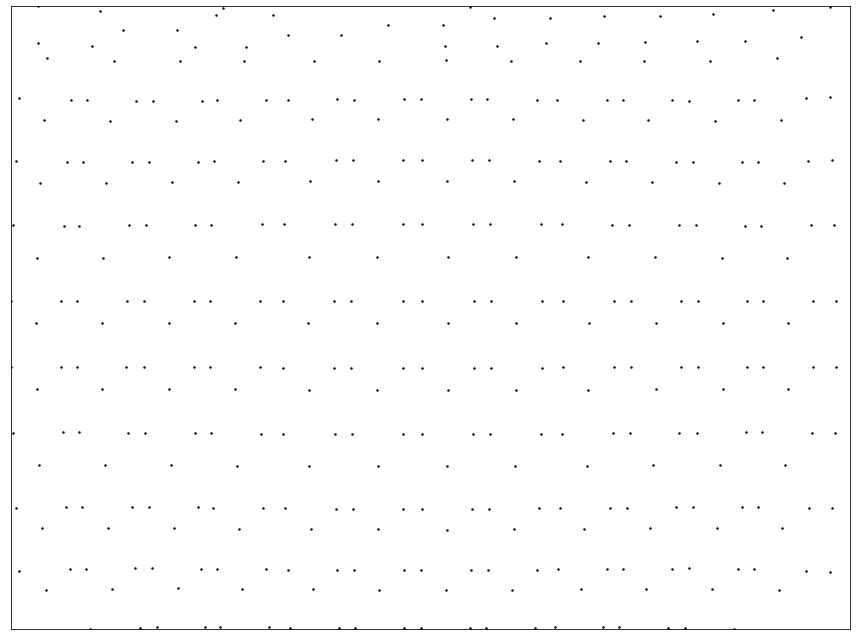

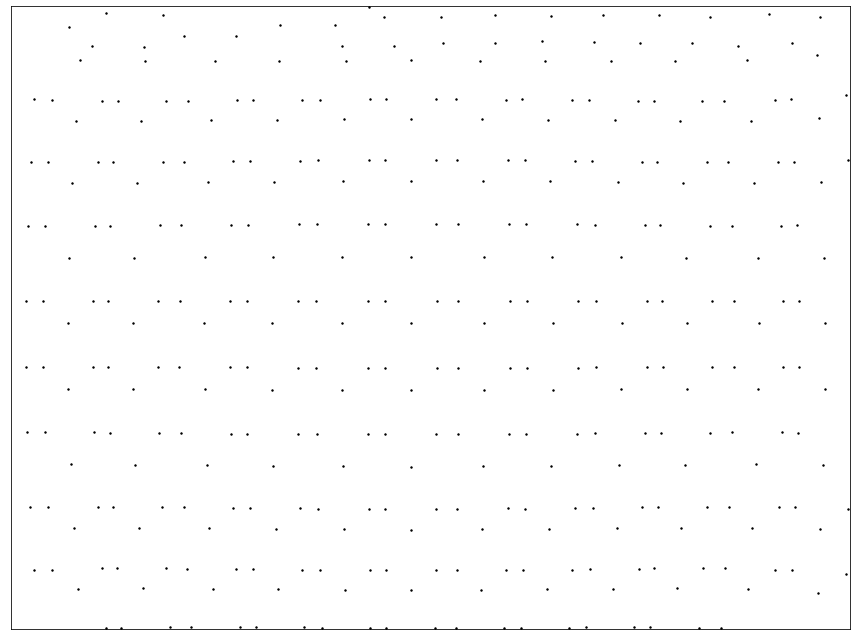

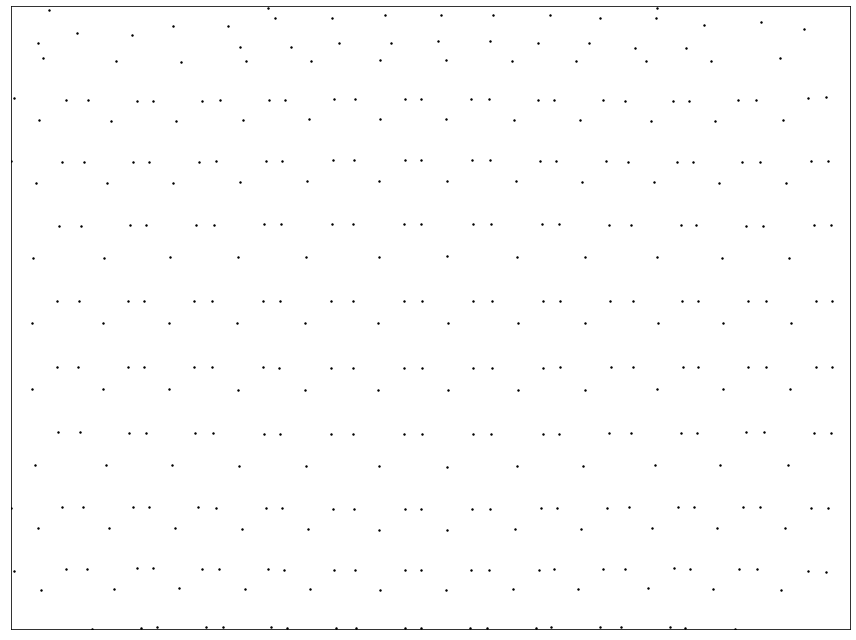

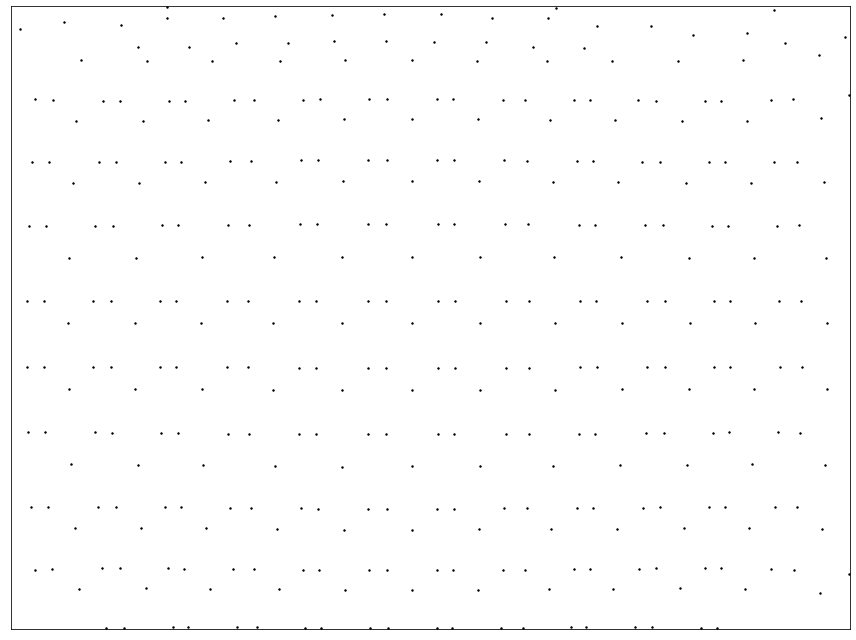

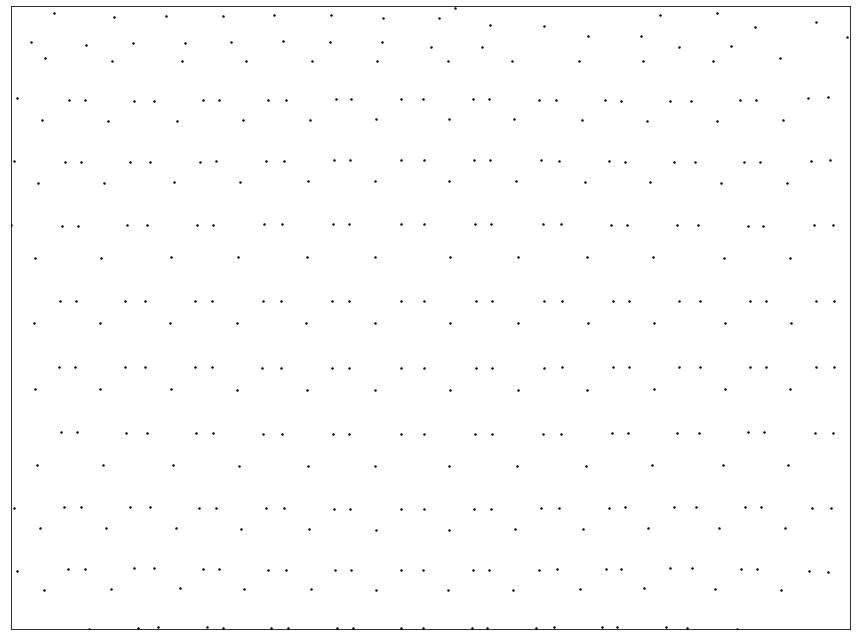

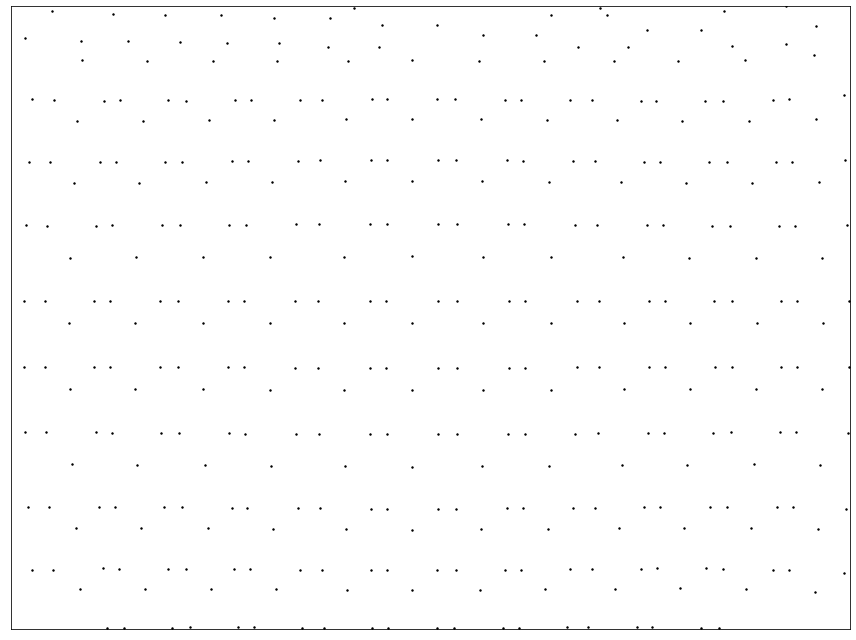

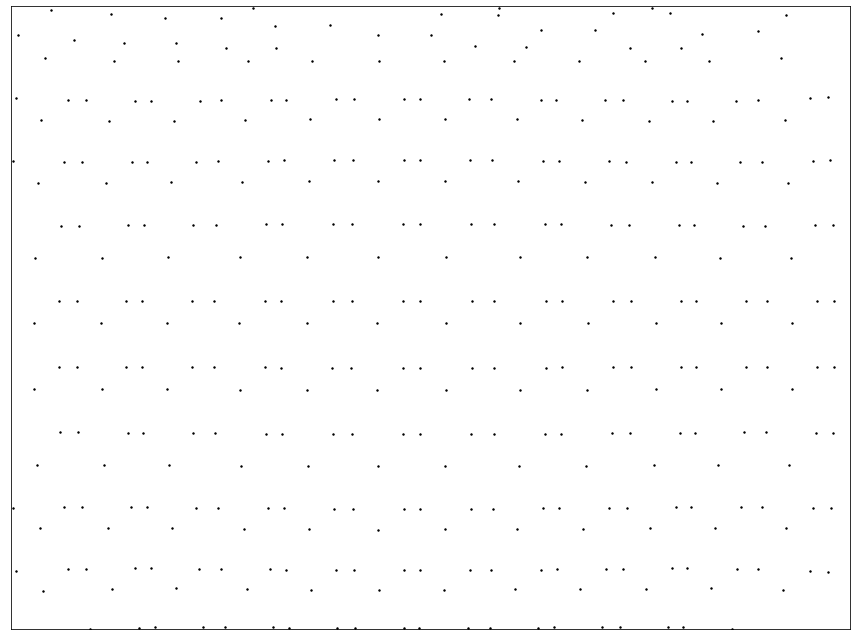

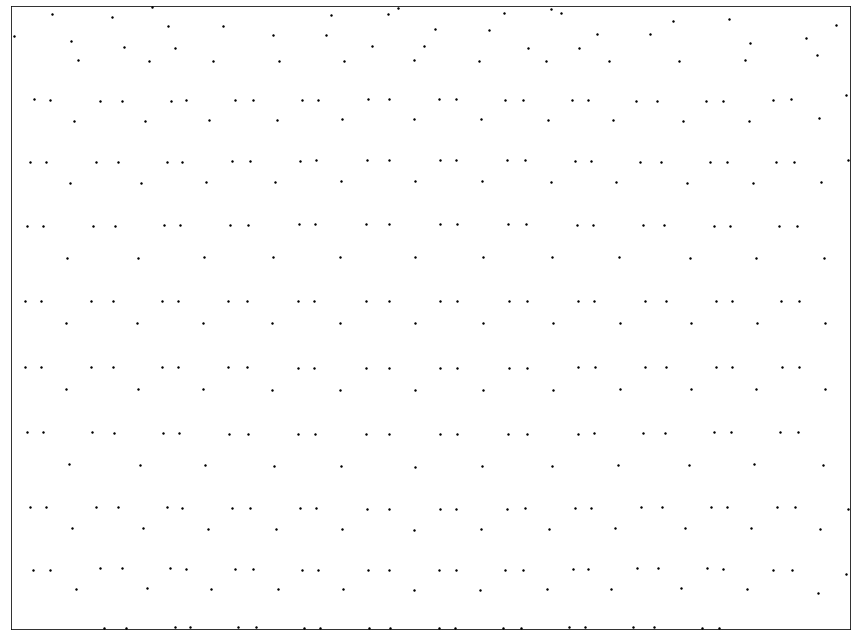

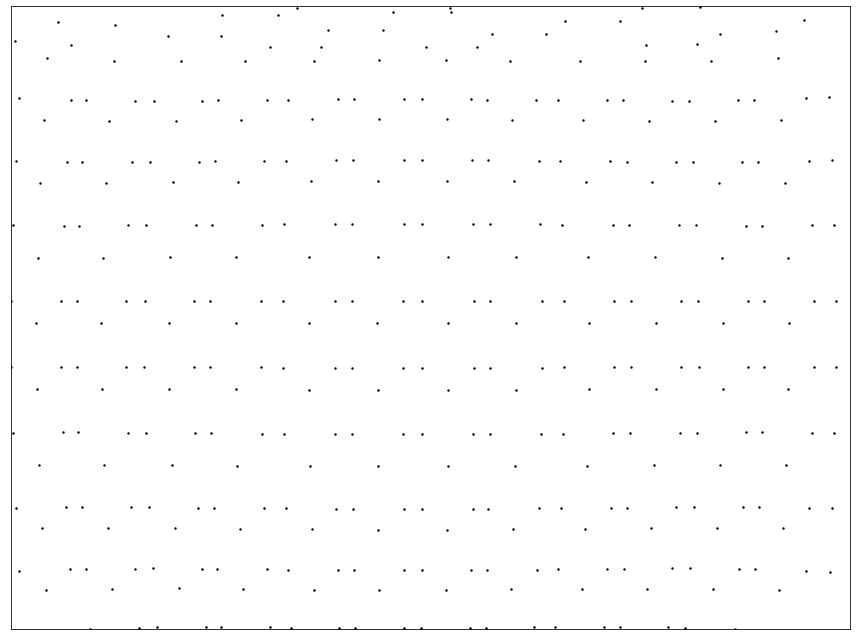

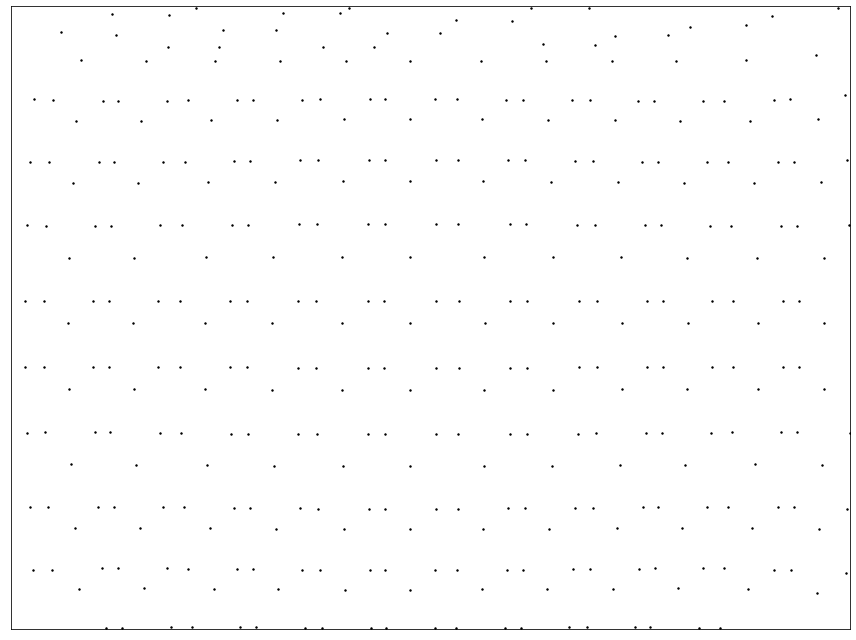

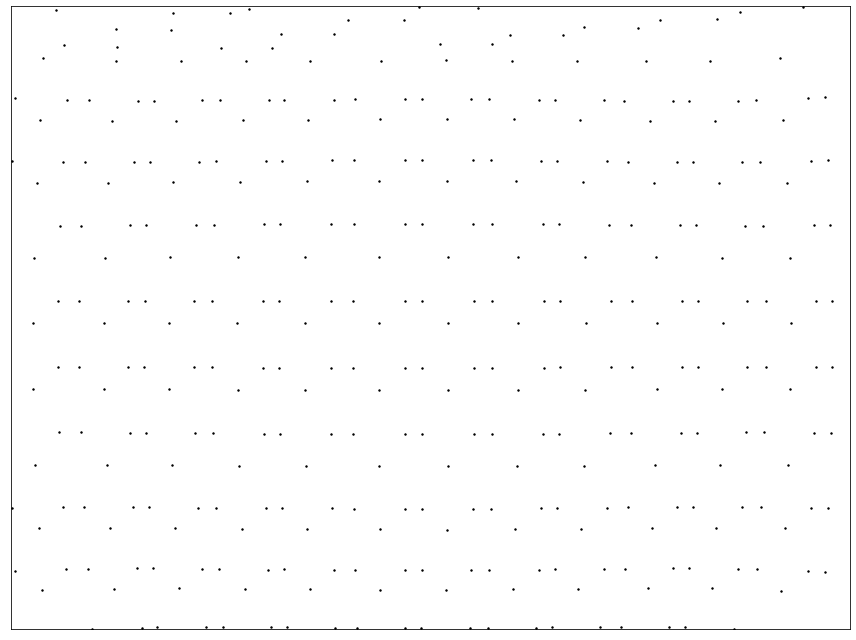

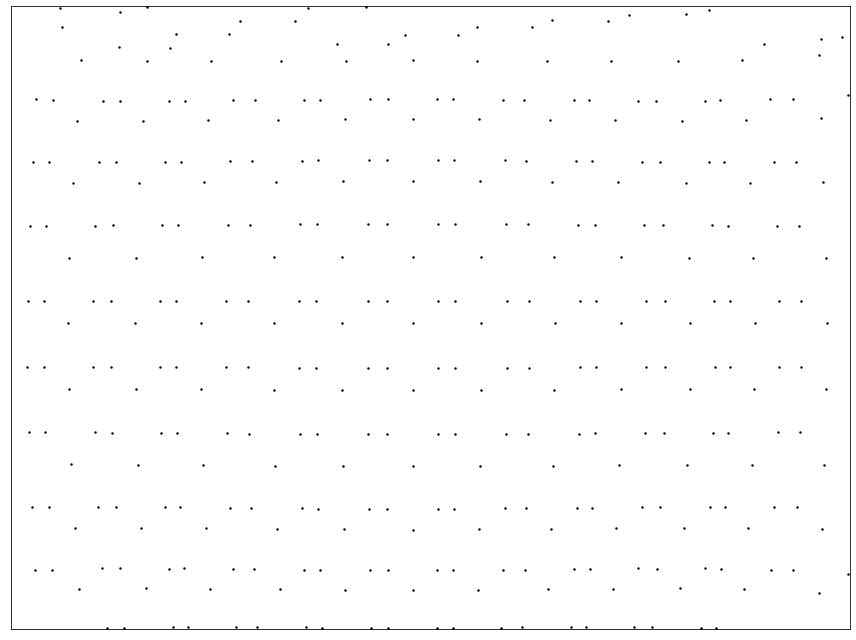

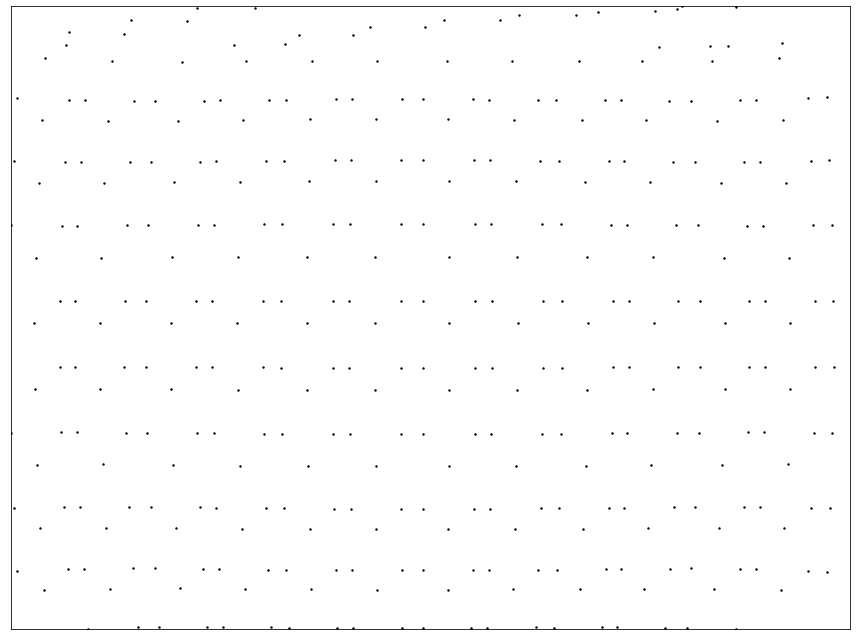

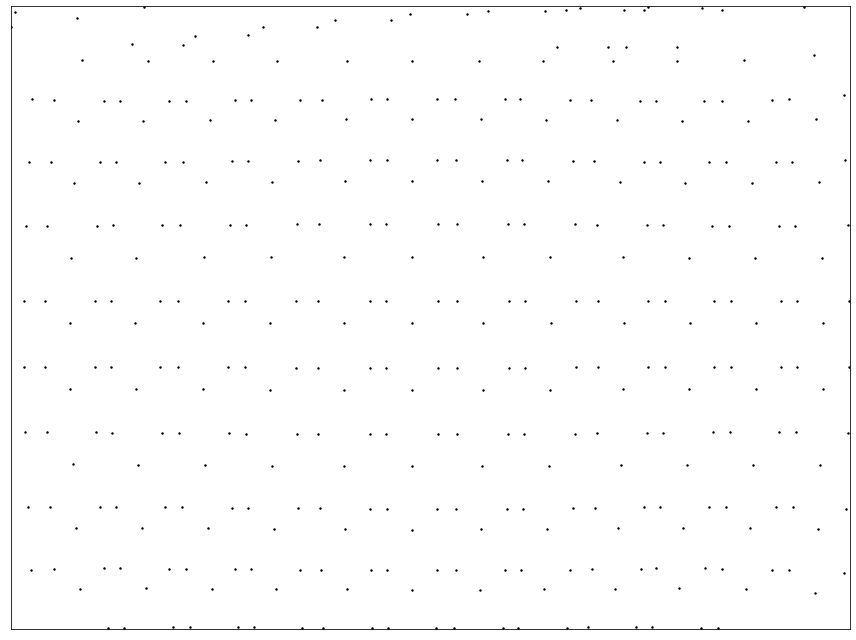

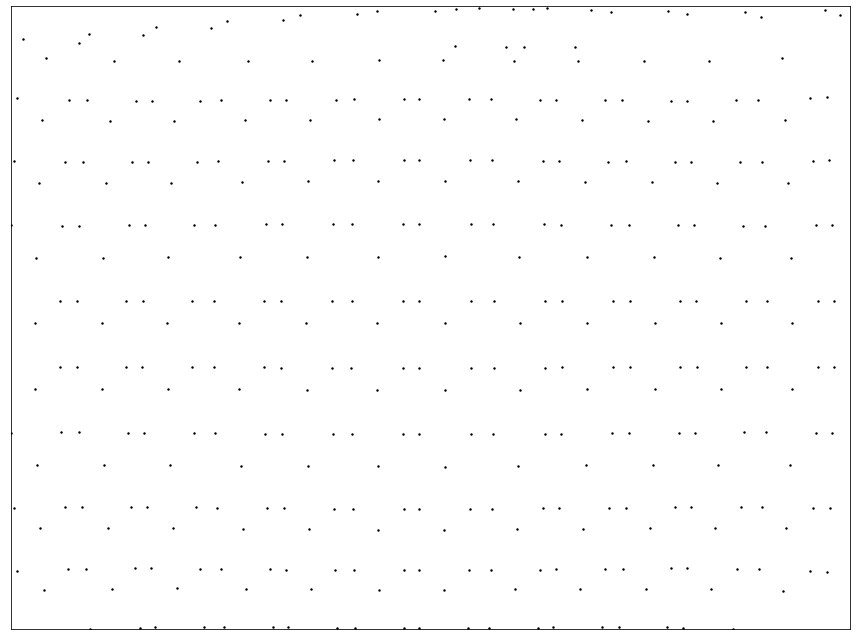

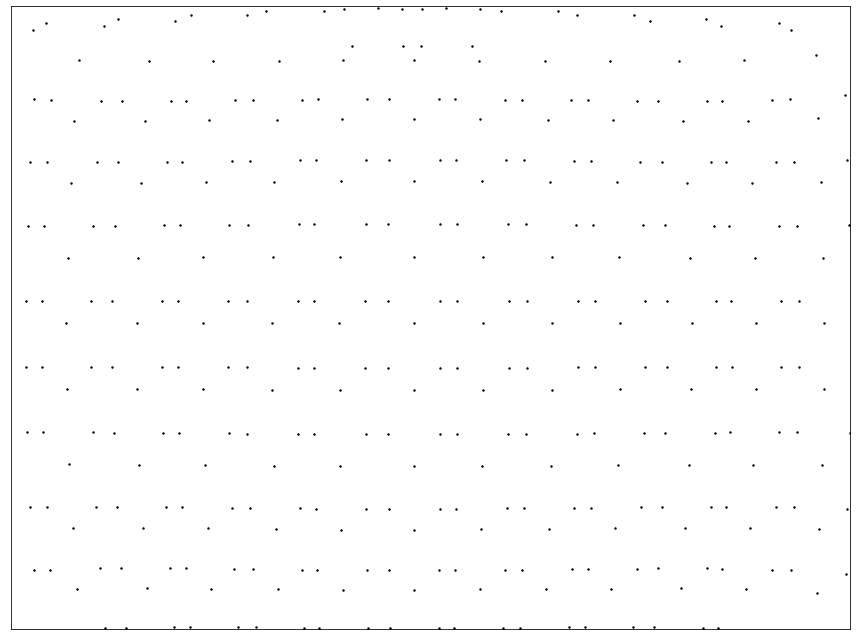

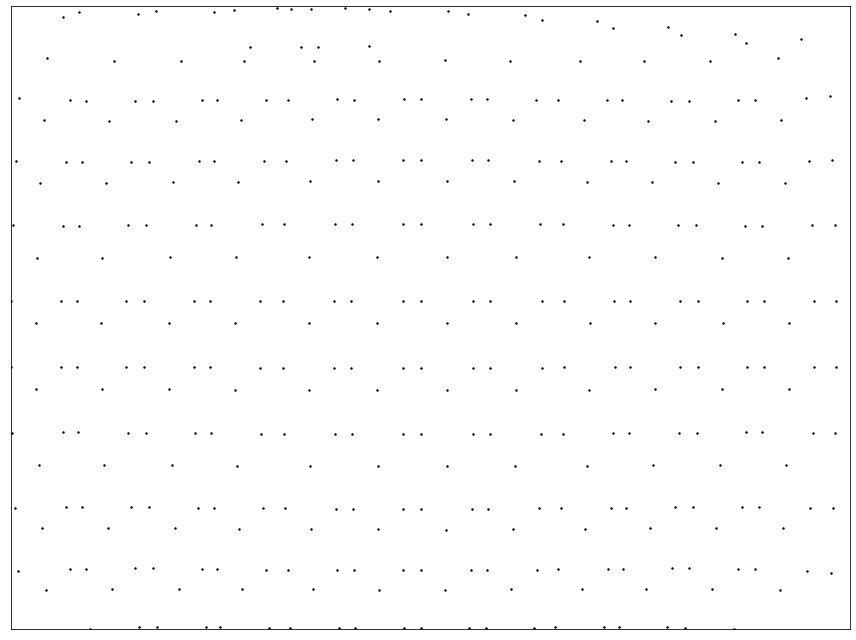

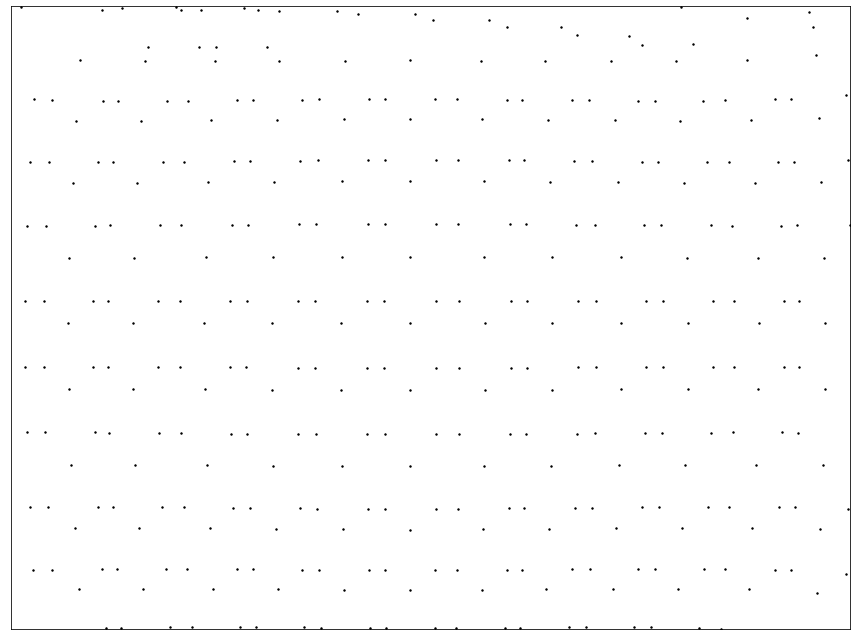

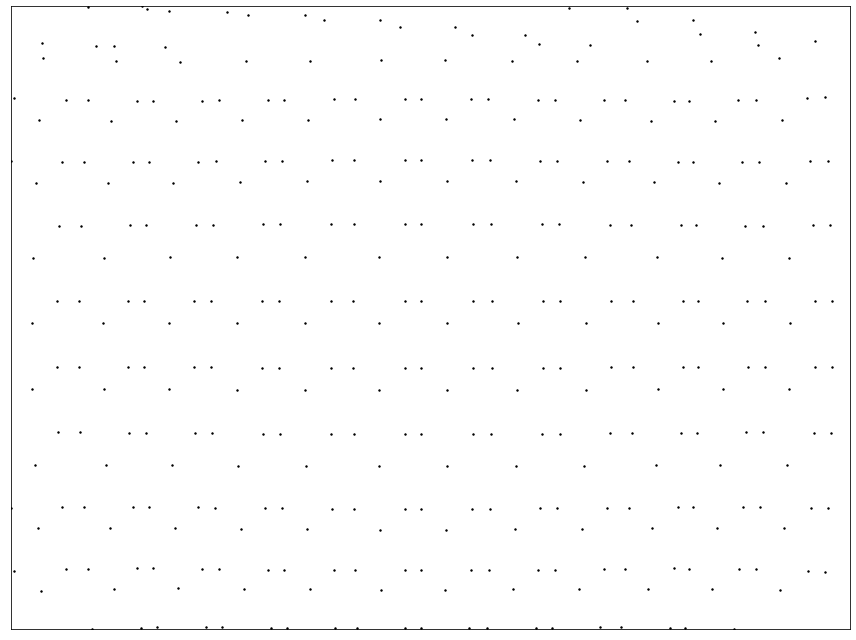

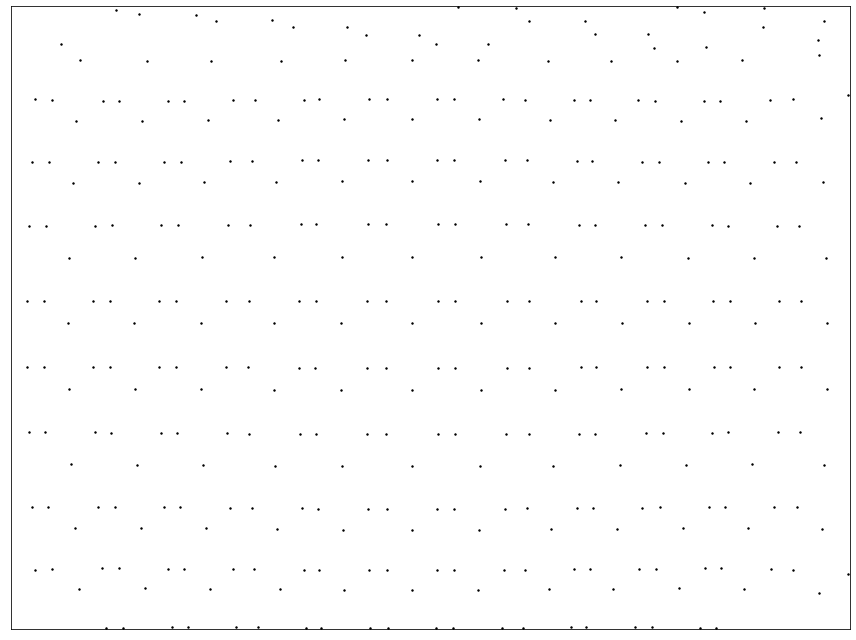

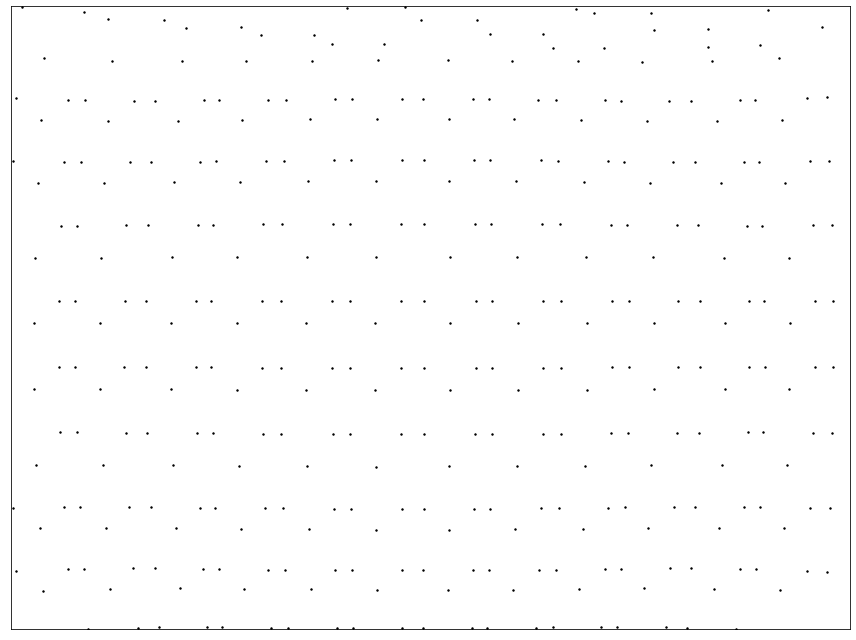

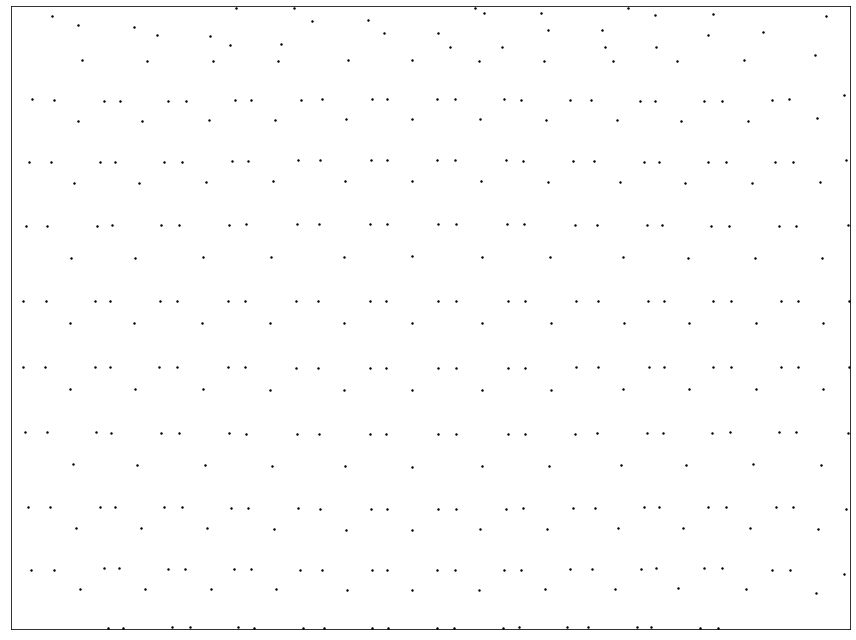

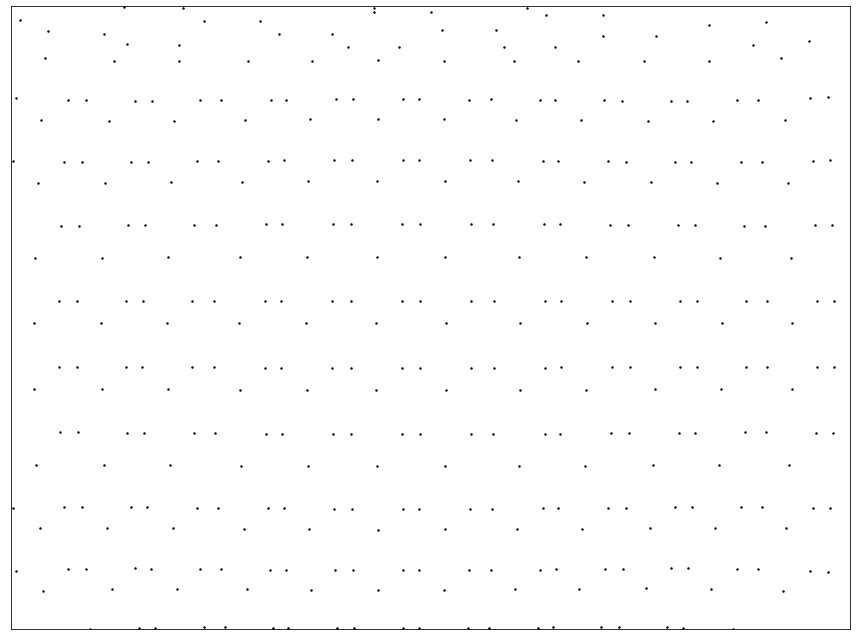

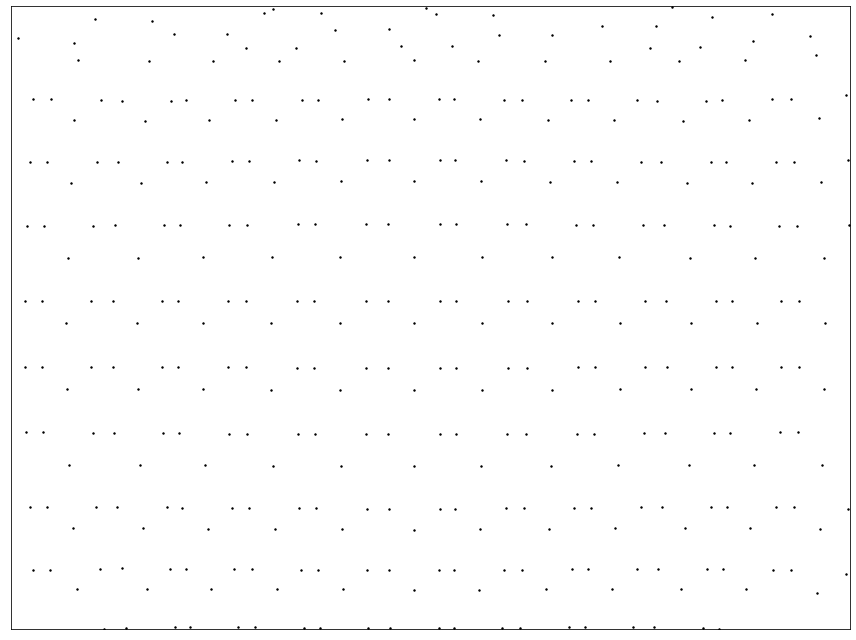

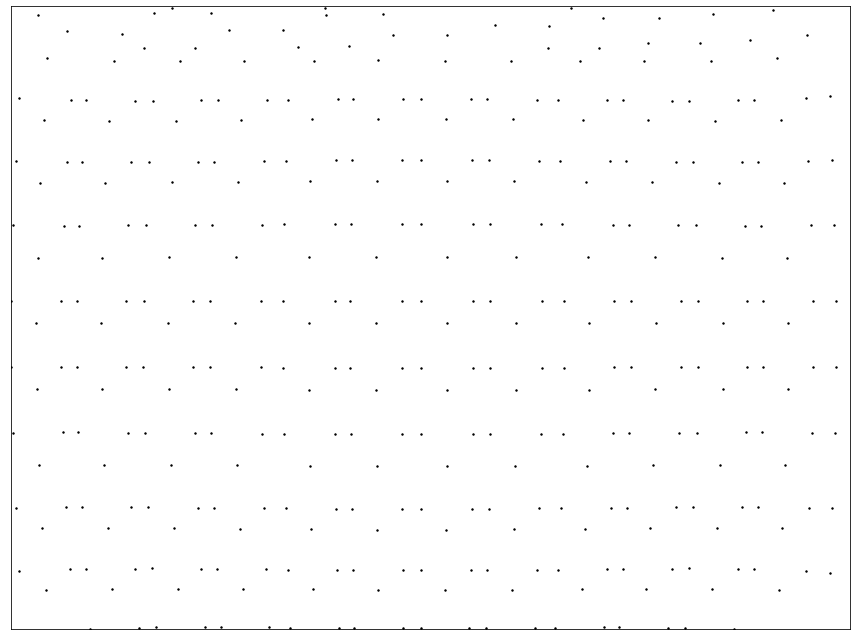

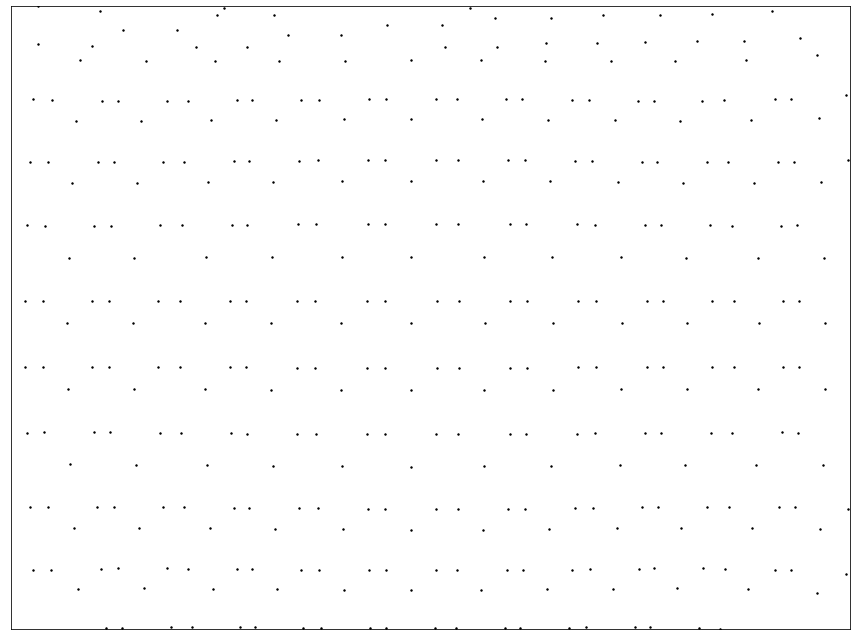

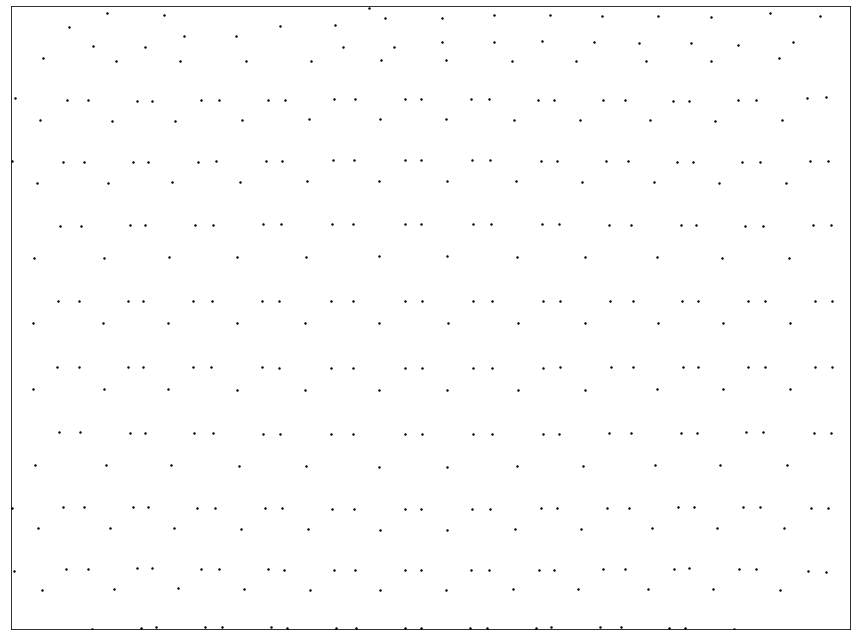

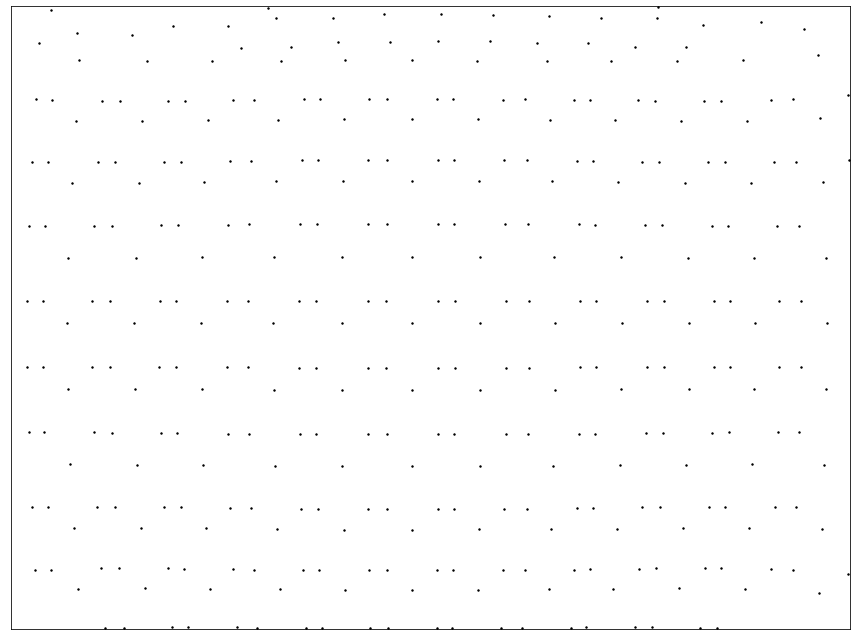

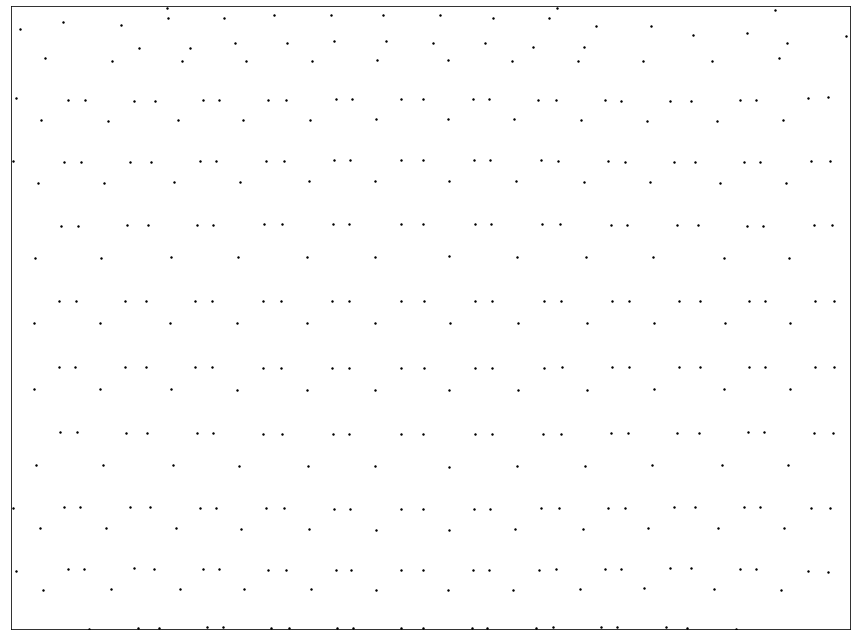

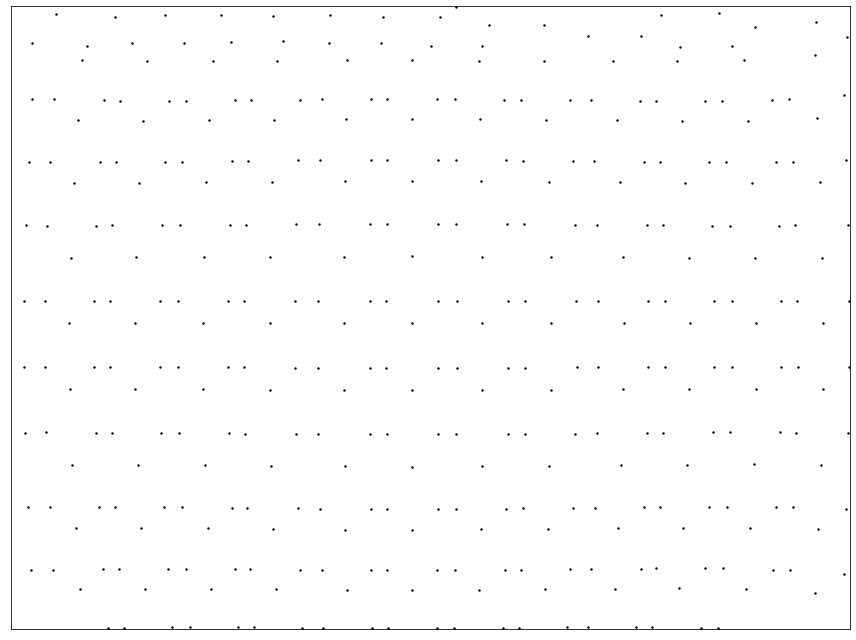

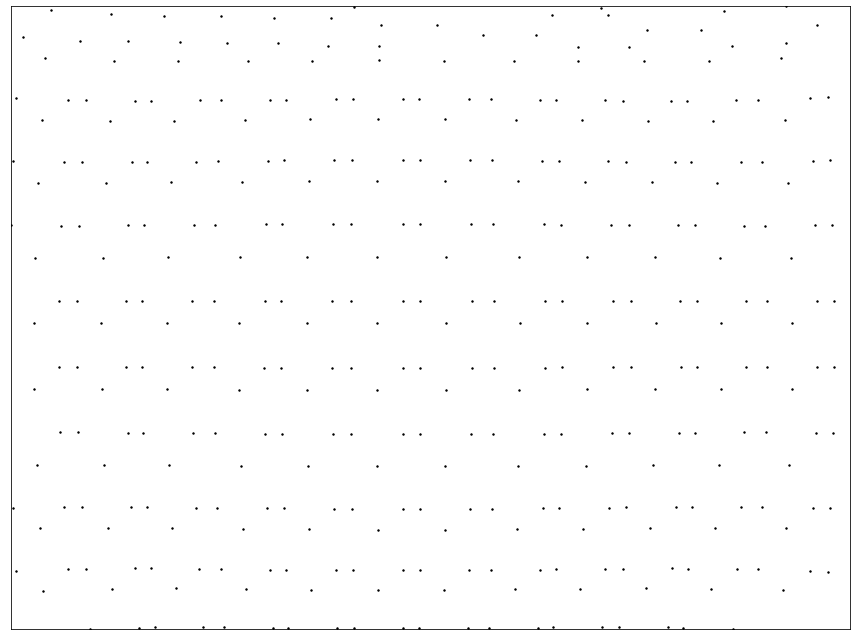

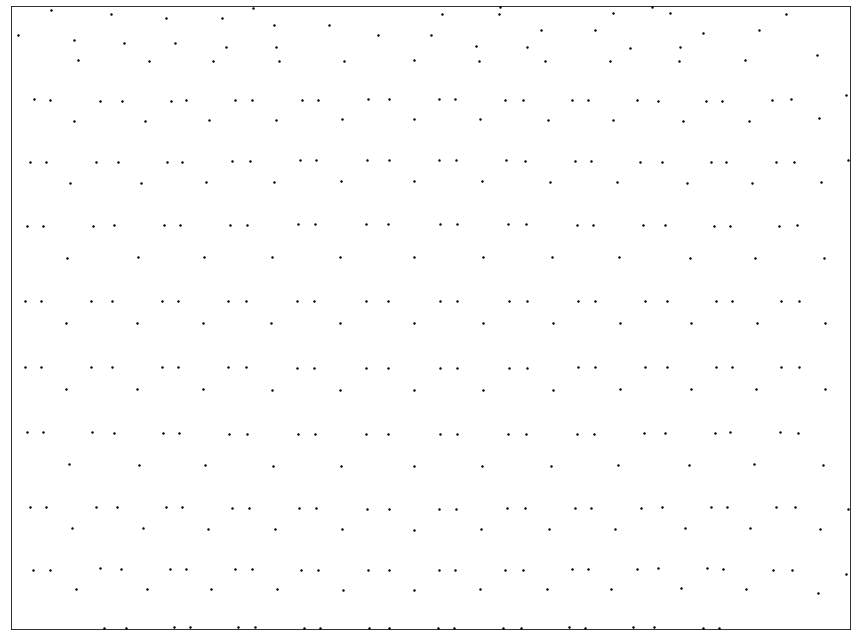

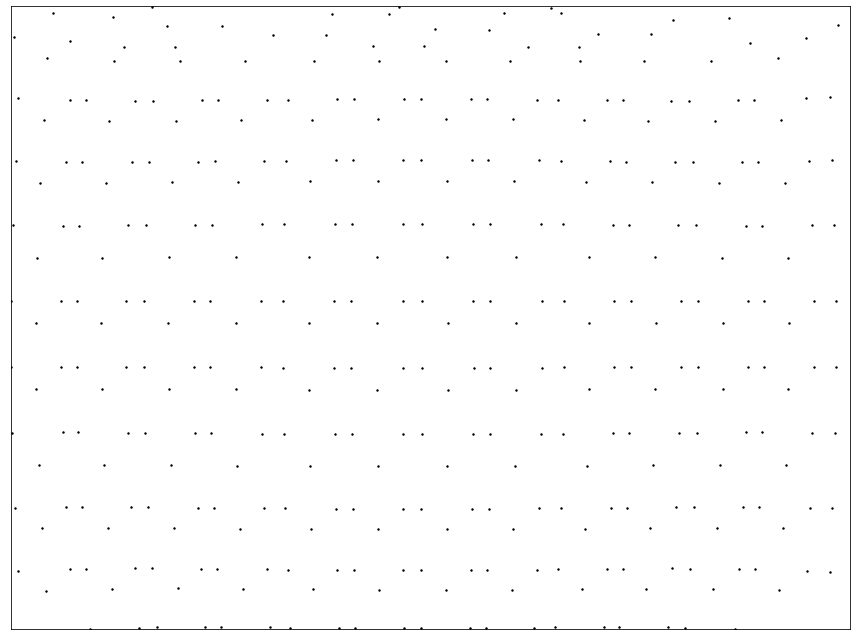

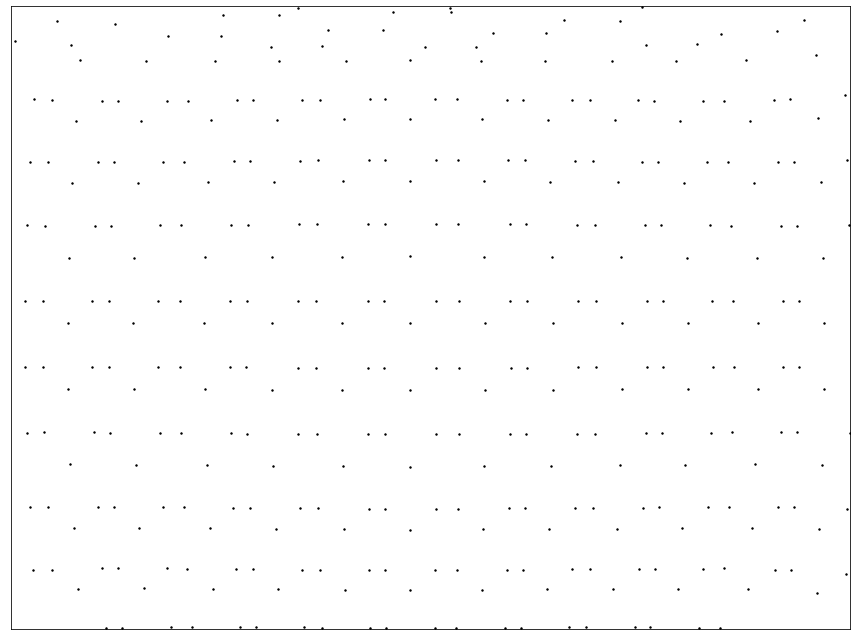

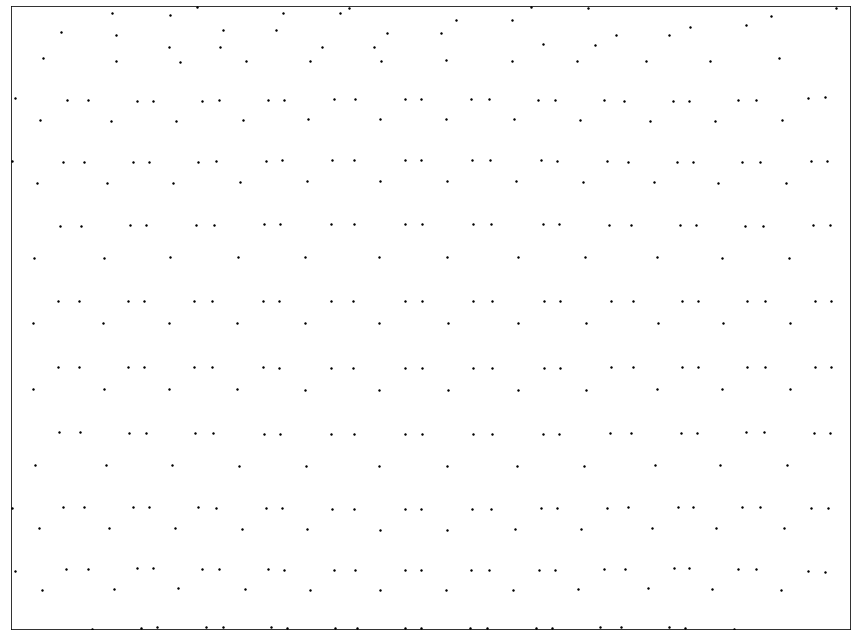

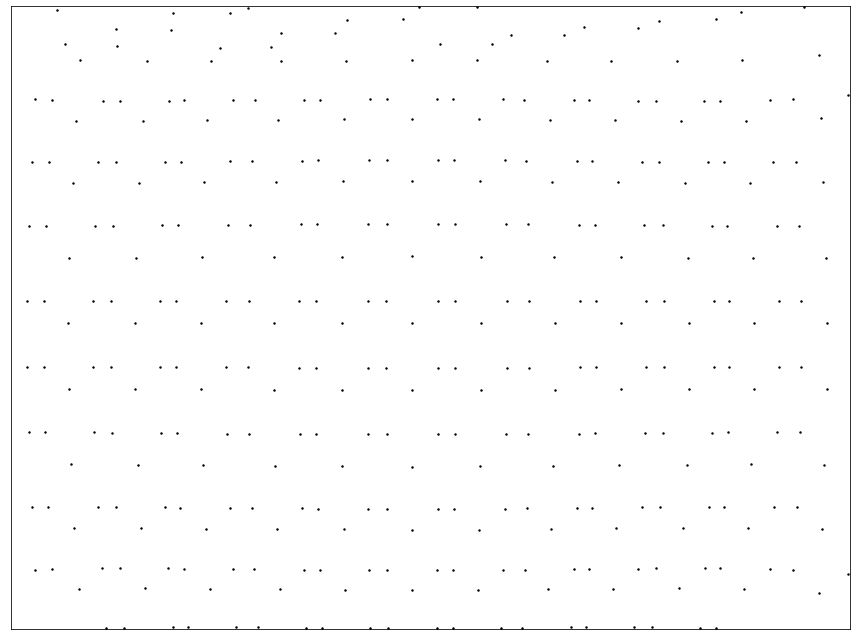

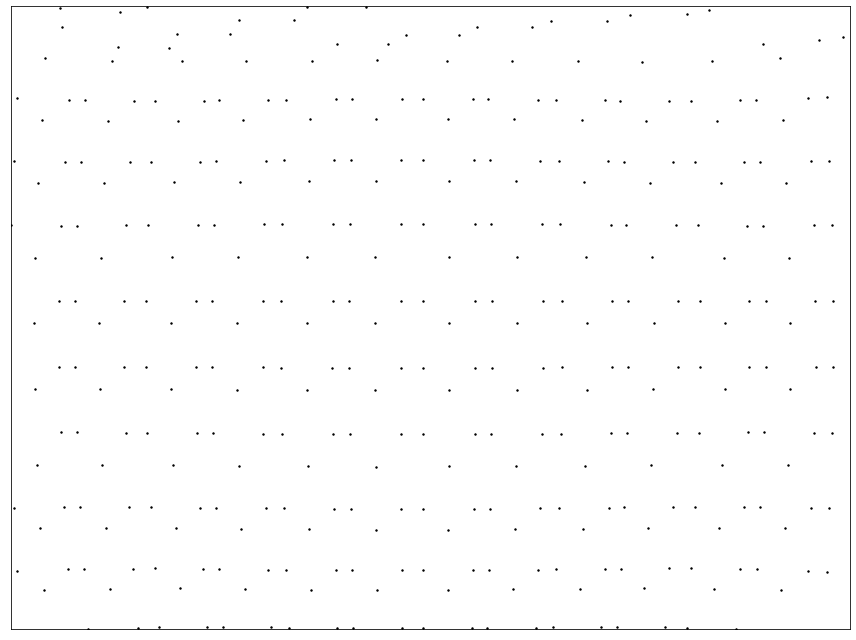

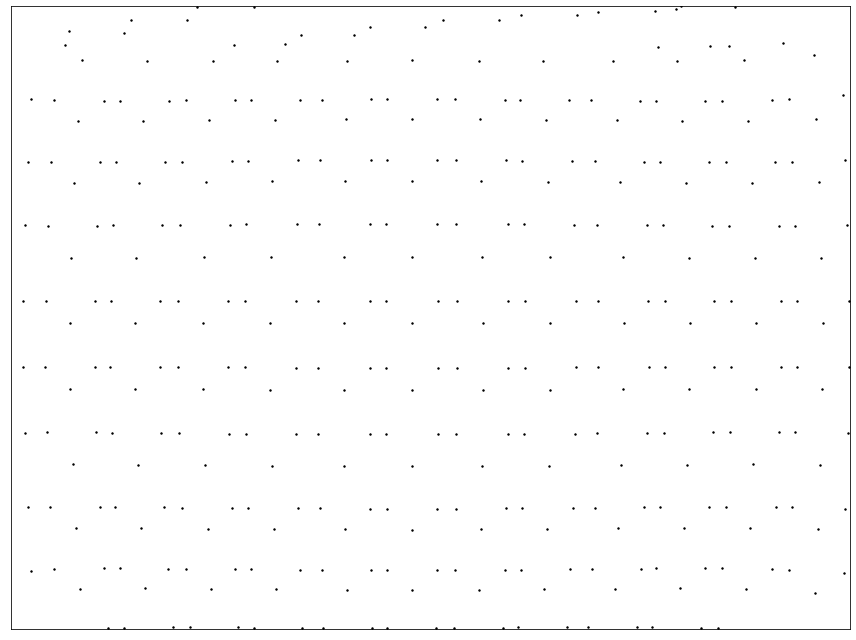

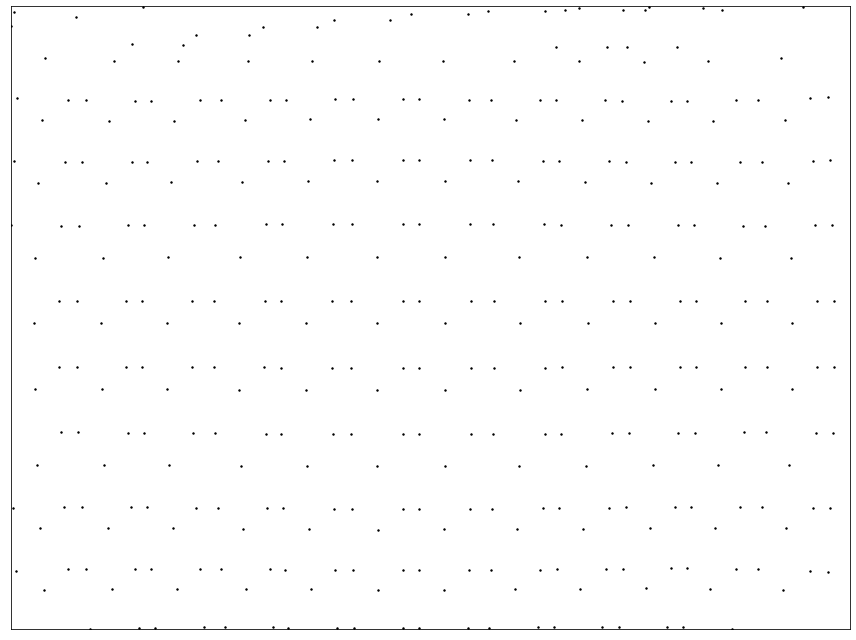

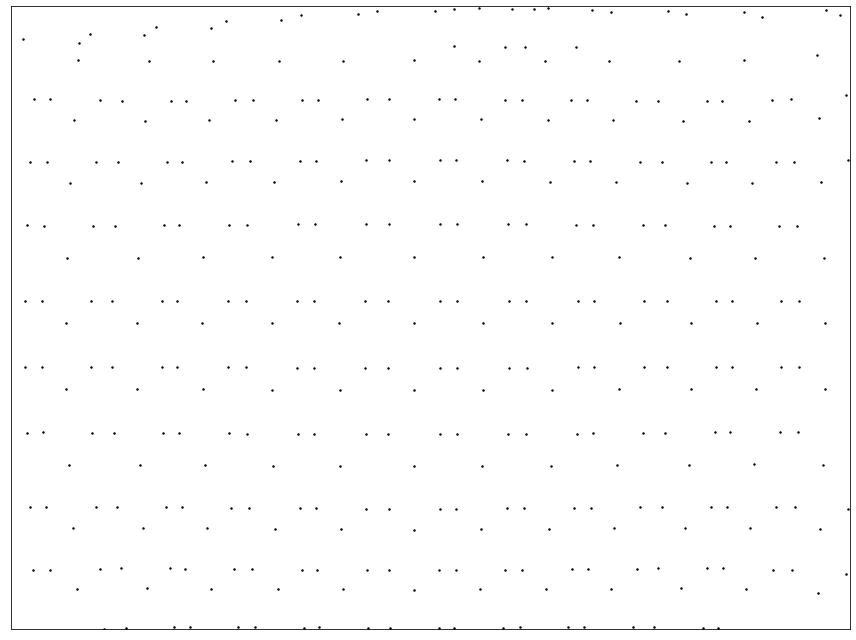

In [63]:
## specify bolt count:
bolt_count = 3

bolt_positions = geo.get_bolt_locations_barrel(pmt_locations, bolt_count)
ring_positions = get_ring_positions(bolt_positions, pmt_locations.keys(), bolt_count)
ring_orientations = get_ring_orientations(bolt_positions, pmt_locations.keys(), bolt_count)
simulator = fit.PhotogrammetrySimulator(bolt_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)
image_feature_locations = simulator.get_image_feature_locations(area_restrict = [[0, 4000], [0, 3000]], min_feature_count = 2)
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
print("Feature in image counts:", Counter(feature_counts.values()))
simulator.show_images(image_feature_locations, area=[[0,4000],[0,3000]])

=== Gaussian errors on feature image locations: 0.5 ===
Feature in image counts: Counter({8: 3421, 9: 523, 7: 318, 6: 160, 5: 20})
100 images with total of  4442 features
image 0 reprojection errors:    average:6.407143880528387   max: 16.97353459805112
image 1 reprojection errors:    average:6.306439942778829   max: 15.03897759901797
image 2 reprojection errors:    average:6.623434135614358   max: 20.01850098584705
image 3 reprojection errors:    average:6.370952790394348   max: 16.92356485072678
image 4 reprojection errors:    average:6.30655222087072   max: 17.520610215626846
image 5 reprojection errors:    average:6.044669691664552   max: 17.269061950026305
image 6 reprojection errors:    average:6.242145665329885   max: 21.129469344374886
image 7 reprojection errors:    average:6.4610790711675055   max: 20.871790611260657
image 8 reprojection errors:    average:6.250986972432281   max: 21.316717143541894
image 9 reprojection errors:    average:6.011064213002103   max: 21.830983869

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.6577e+05                                    7.04e+06    
       1              2         1.9585e+04      8.46e+05       1.03e+02       1.86e+05    
       2              3         6.3576e+03      1.32e+04       4.54e+01       9.63e+04    
       3              4         5.9947e+03      3.63e+02       3.05e+00       2.33e+04    
       4              5         5.8270e+03      1.68e+02       1.50e+00       7.39e+03    
`xtol` termination condition is satisfied.
Function evaluations 5, initial cost 8.6577e+05, final cost 5.8270e+03, first-order optimality 7.39e+03.
mean reprojection error: 0.5049726329237171
max reprojection error: 2.6833043025394563
mean reconstruction error: 0.26887452054841493
max reconstruction error: 1.7510386311422814
=== Gaussian errors on feature image locations: 1.0 ===
Feature in image counts: Counter({8: 3421, 9: 523, 7: 318, 6: 160, 5: 2

image 89 reprojection errors:    average:5.968199028462352   max: 15.284413695321263
image 90 reprojection errors:    average:6.076186768417628   max: 17.13800659227574
image 91 reprojection errors:    average:5.953472785520619   max: 17.96445233201442
image 92 reprojection errors:    average:6.14301628370647   max: 15.40885656687354
image 93 reprojection errors:    average:6.028450657063049   max: 17.17805202473732
image 94 reprojection errors:    average:6.314531305008242   max: 22.90986281984896
image 95 reprojection errors:    average:6.108361593563074   max: 21.96729972196619
image 96 reprojection errors:    average:6.424785200391245   max: 22.81158249856994
image 97 reprojection errors:    average:6.568505285214119   max: 22.112317189513835
image 98 reprojection errors:    average:6.405570427818849   max: 21.416469147500177
image 99 reprojection errors:    average:6.40386310097712   max: 21.264901491521304
   Iteration     Total nfev        Cost      Cost reduction    Step norm  

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.8244e+05                                    1.16e+07    
       1              2         1.0152e+05      8.81e+05       1.02e+02       9.53e+04    
       2              3         8.0130e+04      2.14e+04       4.77e+01       1.33e+05    
       3              4         7.6833e+04      3.30e+03       6.98e+00       7.07e+03    
       4              5         7.6642e+04      1.91e+02       1.14e+00       5.25e+04    
`xtol` termination condition is satisfied.
Function evaluations 5, initial cost 9.8244e+05, final cost 7.6642e+04, first-order optimality 5.25e+04.
mean reprojection error: 1.844671825384314
max reprojection error: 7.259607427224846
mean reconstruction error: 0.5125595249312807
max reconstruction error: 2.4791857274657496
=== Gaussian errors on feature image locations: 3.0 ===
Feature in image counts: Counter({8: 3421, 9: 523, 7: 318, 6: 160, 5: 20})

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1073e+06                                    9.29e+06    
       1              2         2.0484e+05      9.02e+05       1.02e+02       6.63e+04    
       2              3         1.8332e+05      2.15e+04       4.06e+01       5.76e+04    
       3              4         1.7531e+05      8.01e+03       9.58e+00       5.86e+03    
       4              5         1.7438e+05      9.29e+02       2.99e+00       3.98e+04    
       5              6         1.7394e+05      4.39e+02       5.74e-01       3.95e+03    
`xtol` termination condition is satisfied.
Function evaluations 6, initial cost 1.1073e+06, final cost 1.7394e+05, first-order optimality 3.95e+03.
mean reprojection error: 2.77785326254444
max reprojection error: 10.773422628357592
mean reconstruction error: 0.6428940436024105
max reconstruction error: 2.5538197795967603


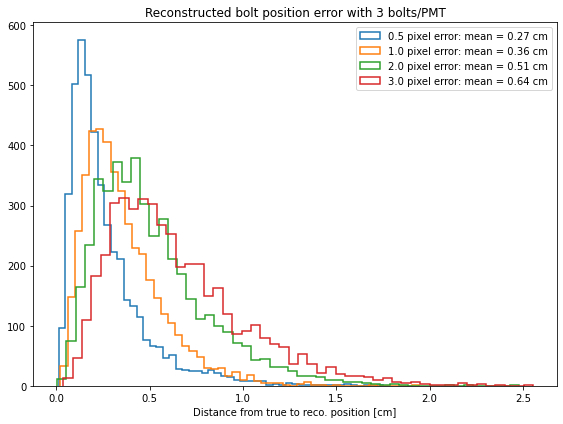

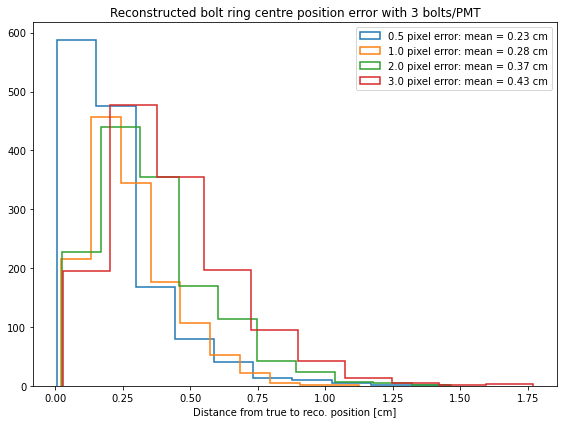

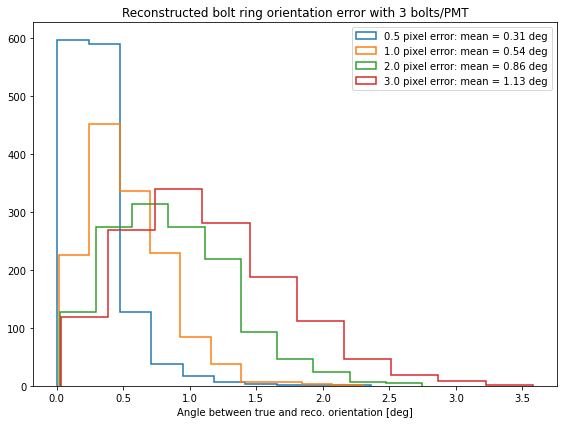

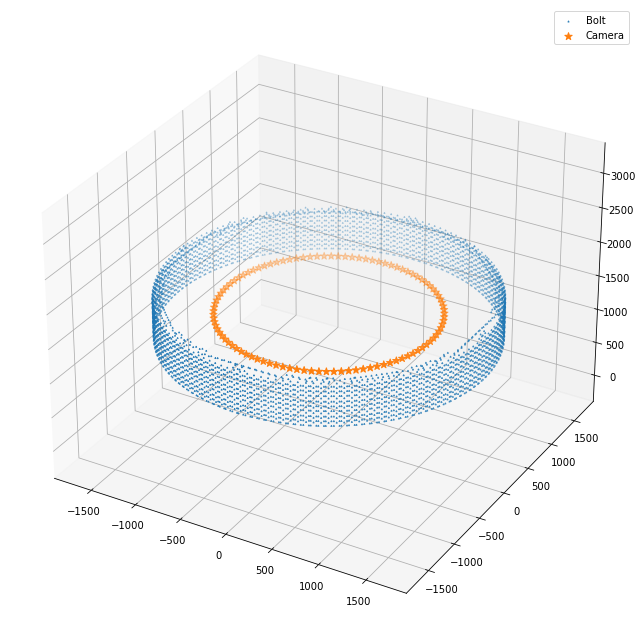

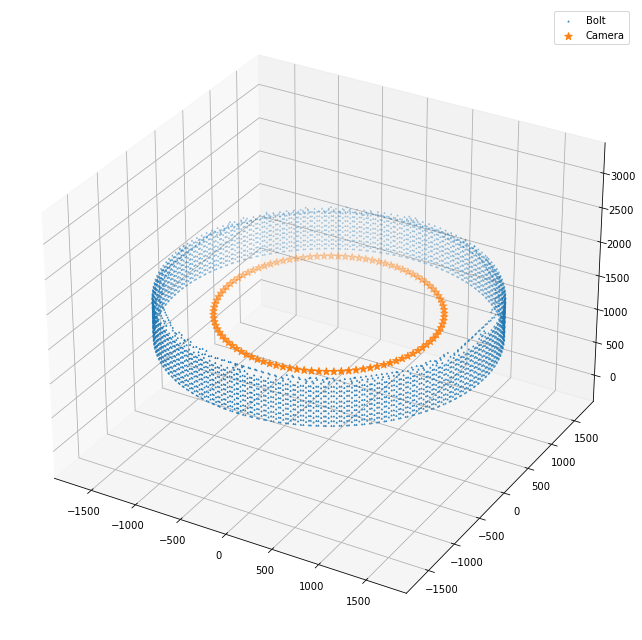

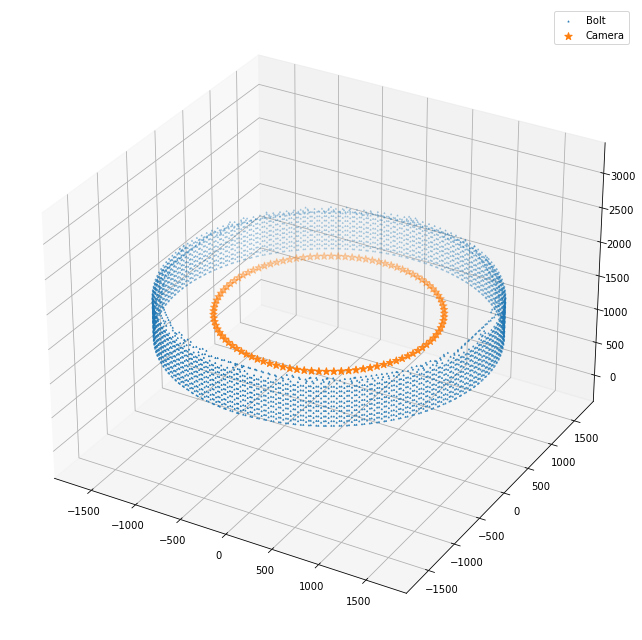

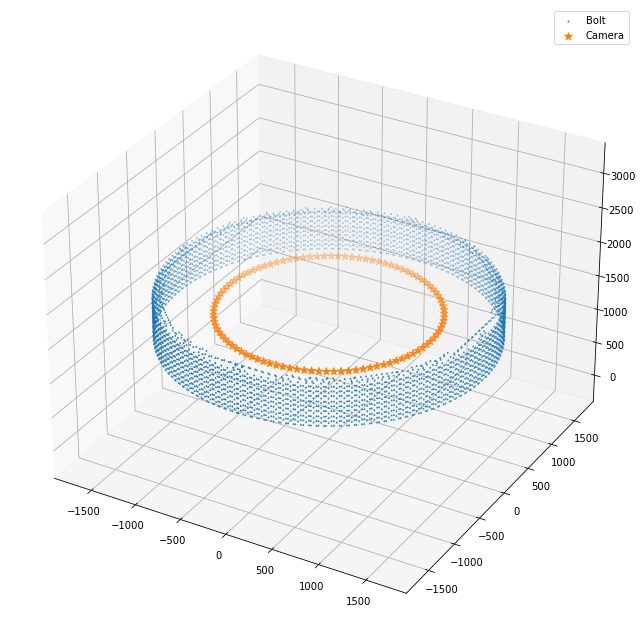

In [64]:
fig_bolt_pos, ax_bolt_pos = make_fig("Reconstructed bolt position error with {} bolts/PMT".format(bolt_count), "Distance from true to reco. position [cm]")
fig_ring_pos, ax_ring_pos = make_fig("Reconstructed bolt ring centre position error with {} bolts/PMT".format(bolt_count), "Distance from true to reco. position [cm]")
fig_ring_ang, ax_ring_ang = make_fig("Reconstructed bolt ring orientation error with {} bolts/PMT".format(bolt_count), "Angle between true and reco. orientation [deg]")
for pixel_error in [0.5, 1.0, 2.0, 3.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=[[0, 4000], [0, 3000]], min_feature_count=2, pixel_error=pixel_error)
    feature_counts = Counter([f for i in smeared_feature_locations.values() for f in i.keys()])
    print("Feature in image counts:", Counter(feature_counts.values()))
    bolt_positions2 = {k: v for k, v in bolt_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_bolt_simulation(bolt_positions2, smeared_feature_locations, focal_length, principle_point, skew, radial_distortion)    
    reco_bolt_positions, position_errors = run_bolt_fit(fitter, bolt_positions2, xtol=1e-5)
    centre_errors = get_ring_centre_errors(reco_bolt_positions, ring_positions, bolt_count)
    orientation_errors = get_ring_orientation_errors(reco_bolt_positions, ring_orientations, bolt_count)
    ax_bolt_pos.hist(position_errors, bins=50, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors.mean()))
    ax_ring_pos.hist(centre_errors, bins=10, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors.mean()))
    ax_ring_ang.hist(orientation_errors, bins=10, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors.mean()))
    reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(bolt_positions, reco_bolt_positions)
    reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(fitter.camera_rotations, fitter.camera_translations)
    plot_reconstruction(reco_transformed, reco_cam_positions)
    bolt_position_errors[bolt_count][pixel_error] = position_errors.mean()
    ring_position_errors[bolt_count][pixel_error] = centre_errors.mean()
    ring_orientation_errors[bolt_count][pixel_error] = orientation_errors.mean()
ax_bolt_pos.legend(loc='upper right')
ax_ring_pos.legend(loc='upper right')
ax_ring_ang.legend(loc='upper right')

In [ ]:
plt.hist(np.linalg.norm(reco_transformed[:,:2], axis=1))